In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score as sil_, calinski_harabasz_score as calinski_
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm
import re
from datetime import datetime, timezone
from sklearn.preprocessing import OneHotEncoder
import ipaddress
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from collections import Counter
import plotly.express as px
import matplotlib.dates as mdates
import folium
import pytz
from timezonefinder import TimezoneFinder
import pickle


C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Data Loading and Initial Preprocessing

In this section, we:
- Import required libraries
- Load the dataset
- Convert timestamps
- Check data quality
- remove duplicates and non some nan values

In [2]:
df = pd.read_csv('data/omnipot.csv')

In [ ]:
df.drop_duplicates(inplace=True)

In [4]:
df.isna().sum()

src_port                0
dst_port                0
timestamp               0
src_as               2657
src_city                5
src_country             0
src_countryCode        42
src_geo_str             0
src_ip                  0
src_proxy               0
src_regionName        171
dst_as                  0
dst_city                0
dst_country             0
dst_countryCode         0
dst_geo_str             0
dst_ip                  0
dst_proxy               0
dst_regionName          0
protocol                0
payload_4kb_hex    209362
dtype: int64

In [5]:
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")

In [6]:
# filling payload nan with "" the ndrop nan that are not in the payload column as empty payloads are valid
df.fillna({"payload_4kb_hex":""}, inplace=True)
df.dropna(inplace=True)

In [7]:
def get_ip_encoding(ipv4):
    oct1, oct2, oct3, oct4 = ipv4.split('.')
    return  int(oct1), int(oct2), int(oct3), int(oct4)

df[['src_oct1', 'src_oct2', 'src_oct3', 'src_oct4']] = df["src_ip"].apply(get_ip_encoding).apply(pd.Series)
df[['dst_oct1', 'dst_oct2', 'dst_oct3', 'dst_oct4']] = df["dst_ip"].apply(get_ip_encoding).apply(pd.Series)

In [8]:
df["src_geo_str"] = df["src_geo_str"].str.split("|").apply(lambda lst: [float(x) for x in lst])
df["dst_geo_str"] = df["dst_geo_str"].str.split("|").apply(lambda lst: [float(x) for x in lst])

# 2. Geographic Feature Engineering

Processing geographical data:
- Convert coordinates to cartesian
- Calculate geographic distributions
- Process city and country information

In [9]:
def get_lat_lon(geo_list):
    lon = float(geo_list[0])
    lat = float(geo_list[1])
    lat_sin = np.sin(np.radians(lat))
    lat_cos = np.cos(np.radians(lat))
    lon_sin = np.sin(np.radians(lon))
    lon_cos = np.cos(np.radians(lon))

    return [lat, lon, lat_sin, lat_cos, lon_sin, lon_cos]


In [10]:
df[["src_lat","src_lon","src_lat_sin", "src_lat_cos", "src_lon_sin", "src_lon_cos"]] = df["src_geo_str"].apply(get_lat_lon).apply(pd.Series)
df[["dst_lat","dst_lon","dst_lat_sin", "dst_lat_cos", "dst_lon_sin", "dst_lon_cos"]] = df["dst_geo_str"].apply(get_lat_lon).apply(pd.Series)

df.drop(["src_geo_str", "dst_geo_str"], inplace=True, axis=1)

## average attack time and attacked time overall and per attacking country 

In [11]:
m = folium.Map(location=[20, 0], zoom_start=2)
n_to_show = 350  # adjust based on performance

# Sample to avoid overcrowding
sample = df[["src_lat", "src_lon", "src_ip", "dst_lat", "dst_lon", "dst_ip"]].dropna().sample(n=min(n_to_show, len(df)))

for row in sample.itertuples(index=False):
    lat, lon, ip, dlat, dlon, dip = row

    folium.CircleMarker(
        location=(lat, lon),
        radius=5, 
        color='red',
        fill=True,
        fill_color='purple',
        fill_opacity=0.7,
        popup=f"Source IP: {ip}"
    ).add_to(m)

    folium.PolyLine(
        locations=[(lat, lon), (dlat, dlon)],
        color='brown',
        weight=2,
        opacity=0.3
    ).add_to(m)

    folium.CircleMarker(
        location=(dlat, dlon),
        radius=6, 
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        popup=f"Destination IP: {dip}"
    ).add_to(m)
m

# 3. Time based attack analysis

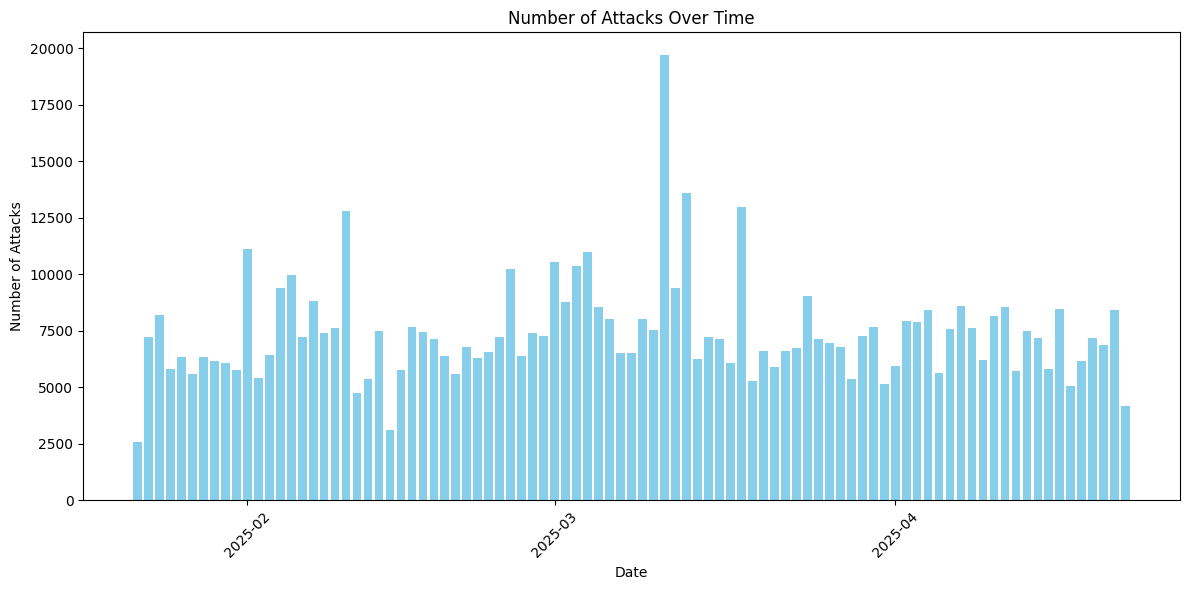

In [ ]:

# Make sure 'date' is datetime64 (not just date)
df["date"] = pd.to_datetime(df["timestamp"].dt.date)

# Count daily attacks
daily_counts = df.groupby("date").size()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(daily_counts.index, daily_counts.values, color='skyblue')

# Format x-axis to show only months
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.title("Number of Attacks Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Attacks")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

df.drop(columns=["date"], inplace=True)

In [13]:
tf = TimezoneFinder()

# Step 1: Ensure timestamp is timezone-aware (UTC)
if df["timestamp"].dt.tz is None:
    df["timestamp"] = df["timestamp"].dt.tz_localize("UTC")

# Step 2: Get timezones from lat/lon
def get_timezone(lat, lon):
    try:
        return tf.timezone_at(lat=lat, lng=lon)
    except:
        return None

df["src_timezone"] = df.apply(lambda row: get_timezone(row["src_lat"], row["src_lon"]), axis=1)
df["dst_timezone"] = df.apply(lambda row: get_timezone(row["dst_lat"], row["dst_lon"]), axis=1)

# Step 3: Convert to local time
def convert_to_local(row, tz_col):
    try:
        if pd.notnull(row[tz_col]):
            tz = pytz.timezone(row[tz_col])
            local_time = row["timestamp"].astimezone(tz)
            return local_time
    except:
        return pd.NaT

df["src_local_time"] = df.apply(lambda row: convert_to_local(row, "src_timezone"), axis=1)
df["dst_local_time"] = df.apply(lambda row: convert_to_local(row, "dst_timezone"), axis=1)

# Extract hour safely from timezone-aware timestamps
df["dst_local_hour"] = df["dst_local_time"].apply(lambda x: x.hour if pd.notnull(x) else np.nan)
df["src_local_hour"] = df["src_local_time"].apply(lambda x: x.hour if pd.notnull(x) else np.nan)

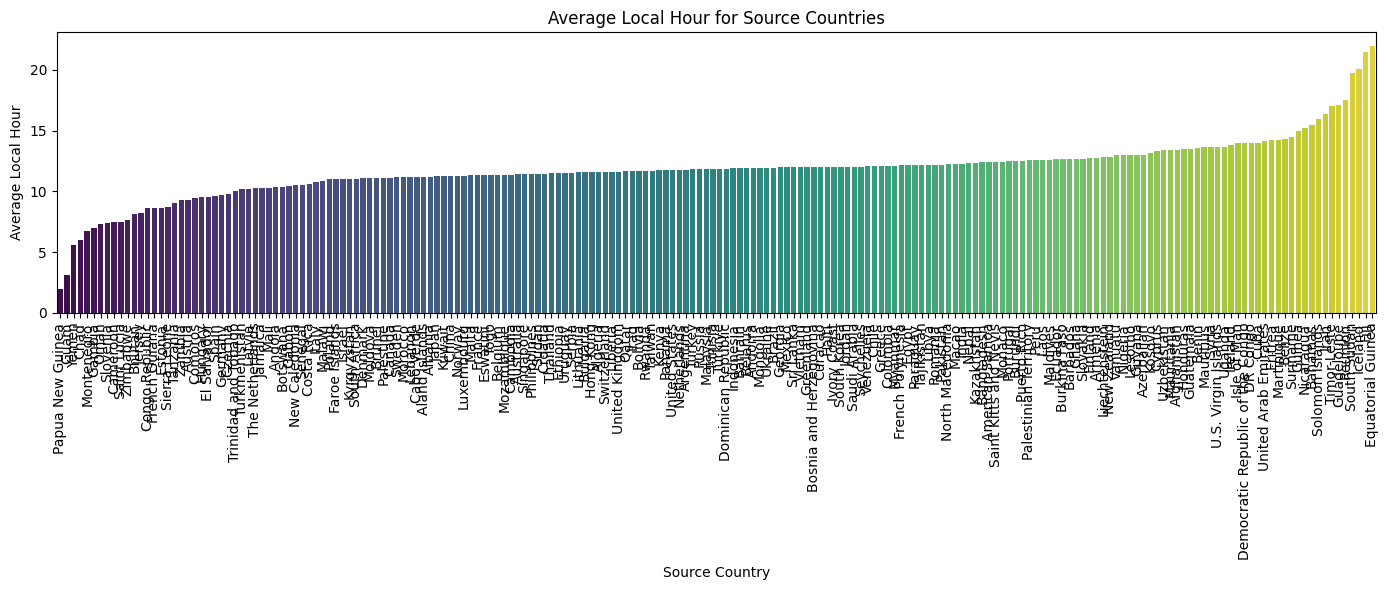

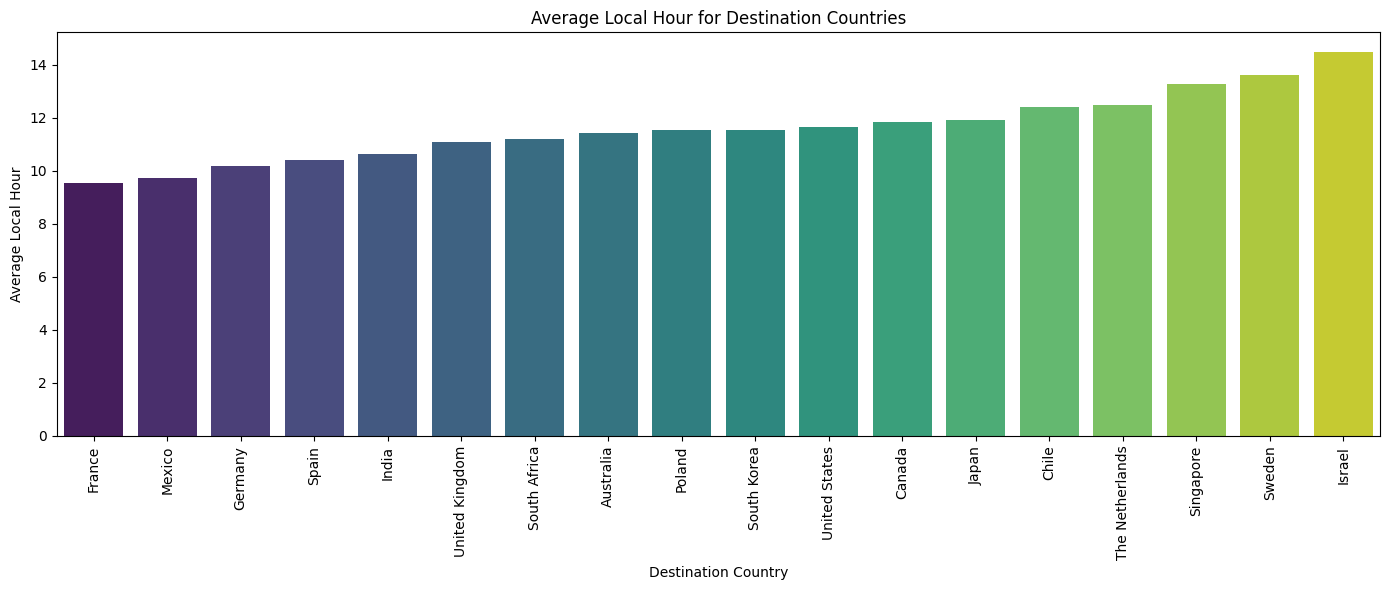

In [14]:
avg_src_by_country = df.groupby("src_country")["src_local_hour"].mean().sort_values()
avg_dst_by_country = df.groupby("dst_country")["dst_local_hour"].mean().sort_values()

plt.figure(figsize=(14, 6))
sns.barplot(x=avg_src_by_country.index, y=avg_src_by_country.values, hue=avg_src_by_country.index, palette="viridis", legend=False)
plt.xticks(rotation=90)
plt.title("Average Local Hour for Source Countries")
plt.xlabel("Source Country")
plt.ylabel("Average Local Hour")
plt.tight_layout()

plt.figure(figsize=(14, 6))
sns.barplot(x=avg_dst_by_country.index, y=avg_dst_by_country.values, hue=avg_dst_by_country.index, palette="viridis", legend=False)
plt.xticks(rotation=90)
plt.title("Average Local Hour for Destination Countries")
plt.xlabel("Destination Country")
plt.ylabel("Average Local Hour")
plt.tight_layout()

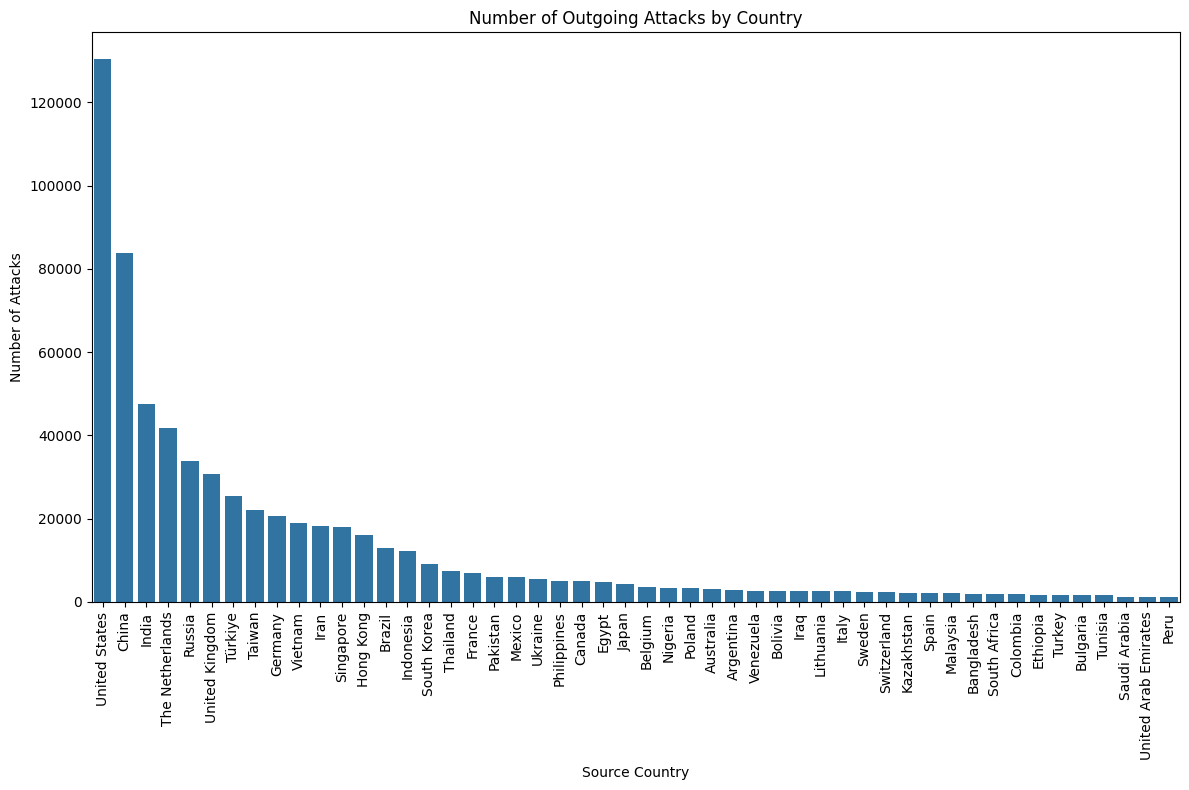

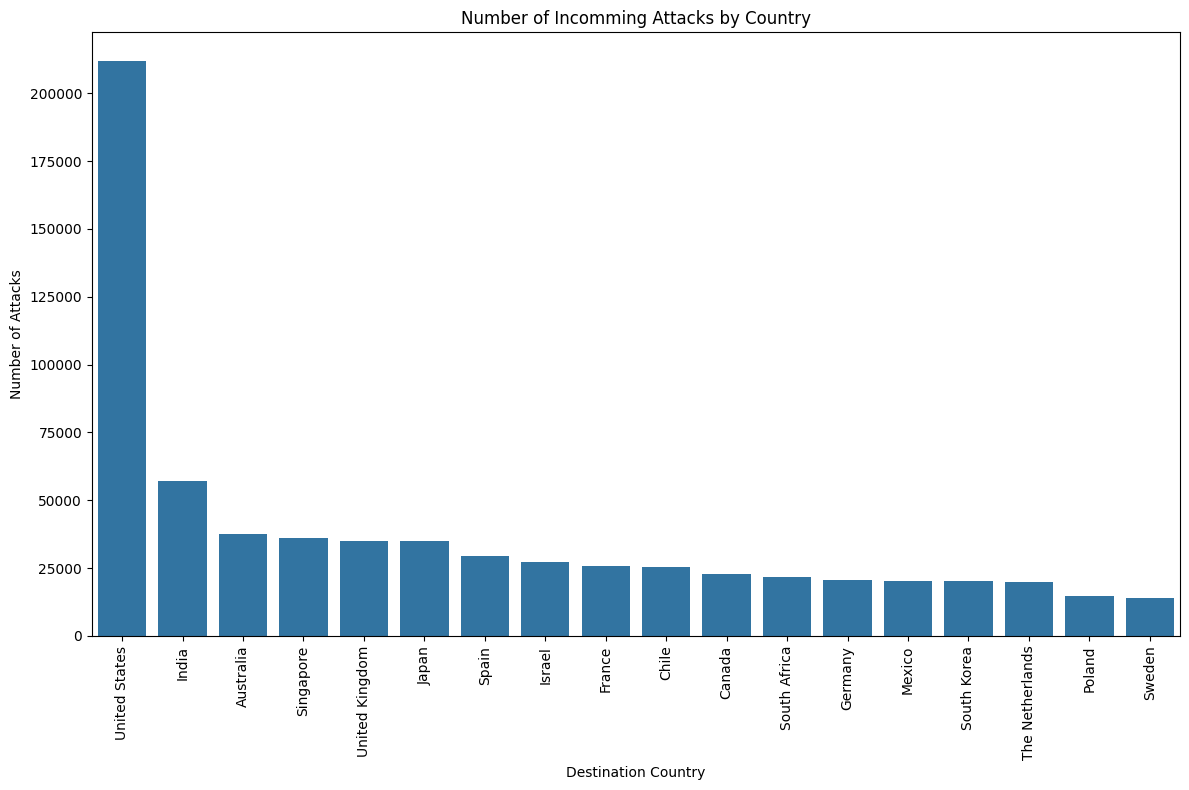

In [15]:
src_attack_counts = df["src_country"].value_counts().head(50)
dst_attack_counts = df["dst_country"].value_counts().head(50)

plt.figure(figsize=(12, 8))
sns.barplot(x=src_attack_counts.index, y=src_attack_counts.values)
plt.xticks(rotation=90)
plt.title("Number of Outgoing Attacks by Country")
plt.xlabel("Source Country")
plt.ylabel("Number of Attacks")
plt.tight_layout()


plt.figure(figsize=(12, 8))
sns.barplot(x=dst_attack_counts.index, y=dst_attack_counts.values)
plt.xticks(rotation=90)
plt.title("Number of Incomming Attacks by Country")
plt.xlabel("Destination Country")
plt.ylabel("Number of Attacks")
plt.tight_layout()
plt.show()

## 3.1 Temporal Feature engeneering

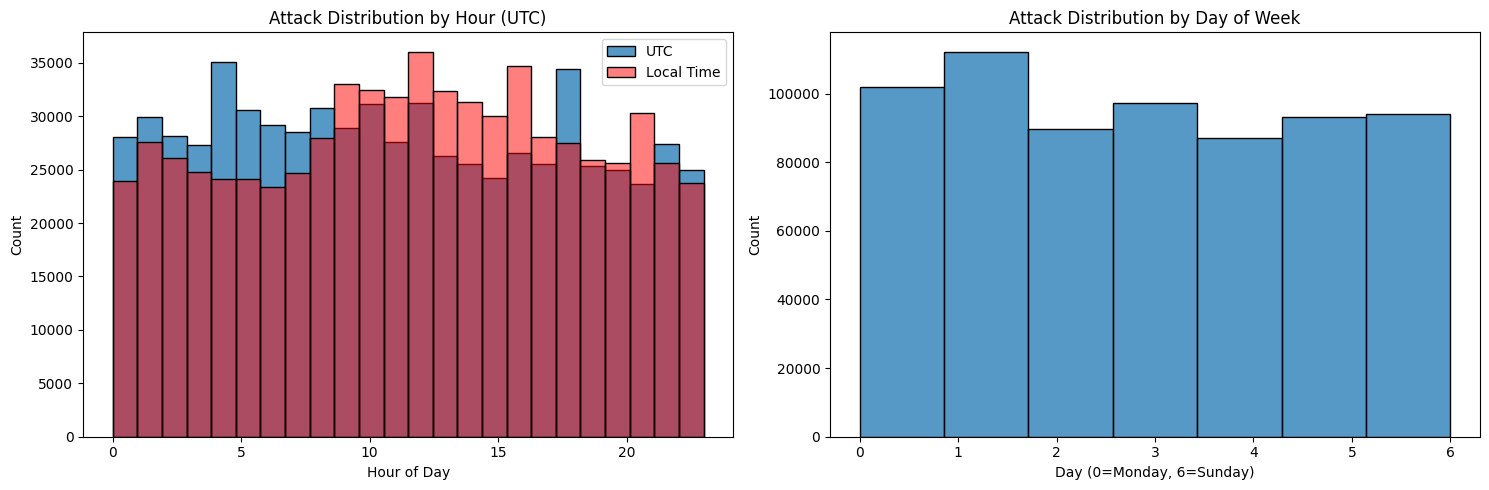

In [16]:
# Time-based features using timezone-aware timestamps
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = df['timestamp'].dt.dayofweek.isin([5,6]).astype(int)

# Plot attack frequency by hour and day
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Attacks by hour
sns.histplot(data=df, x='hour', bins=24, ax=ax1)
ax1.set_title('Attack Distribution by Hour (UTC)')
ax1.set_xlabel('Hour of Day')

# Also show local hour distribution
sns.histplot(data=df, x='src_local_hour', bins=24, ax=ax1, alpha=0.5, color='red', label='Local Time')
ax1.legend(['UTC', 'Local Time'])

# Attacks by day
sns.histplot(data=df, x='day_of_week', bins=7, ax=ax2)
ax2.set_title('Attack Distribution by Day of Week')
ax2.set_xlabel('Day (0=Monday, 6=Sunday)')
plt.tight_layout()

## 3.2 Inter-Attack Time Analysis
We analyze the time differences between consecutive attacks from the same source IP address. This helps identify:
- Automated attacks (very short, consistent intervals)
- Human-driven attacks (longer, more variable intervals)
- Batch processing patterns (regular peaks in activity)

Text(0, 0.5, 'Count (log scale)')

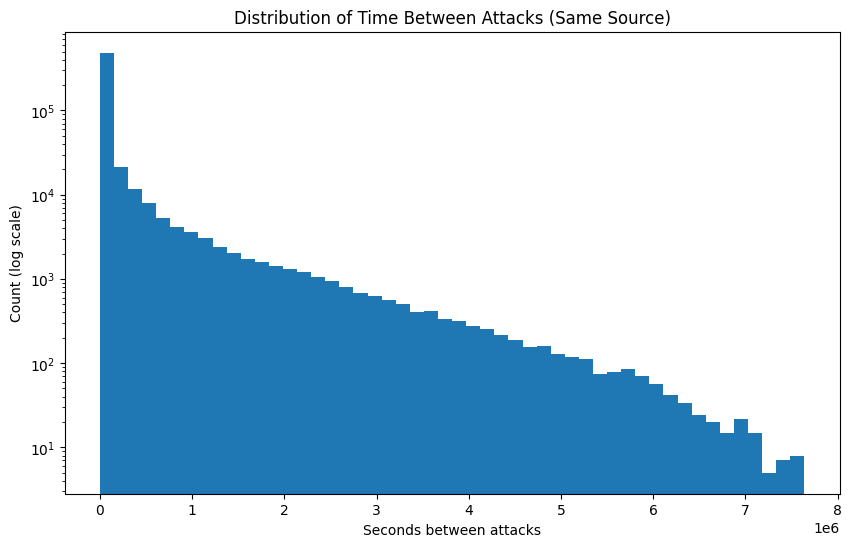

In [17]:
# Calculate time differences between attacks from same source
df_sorted = df.sort_values('timestamp')

# Ensure we're working with timezone-aware timestamps
df_sorted['time_diff'] = df_sorted.groupby('src_ip')['timestamp'].transform(lambda x: x.diff().dt.total_seconds())

# Plot time differences distribution
plt.figure(figsize=(10, 6))
plt.hist(df_sorted['time_diff'].dropna(), bins=50, log=True)
plt.title('Distribution of Time Between Attacks (Same Source)')
plt.xlabel('Seconds between attacks')
plt.ylabel('Count (log scale)')

In [18]:
# Classify time differences into categories
def classify_time_diff(seconds):
    if pd.isnull(seconds):
        return 'unknown'
    elif seconds < 1:
        return 'sub_second'
    elif seconds < 60:
        return '1-60sec'
    elif seconds < 3600:
        return '1-60min'
    elif seconds < 86400:
        return '1-24hr'
    else:
        return '>24hr'

df_sorted['time_category'] = df_sorted['time_diff'].apply(classify_time_diff)

C:\Users\luca.lucchina\AppData\Local\Temp\ipykernel_13352\1166020347.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')


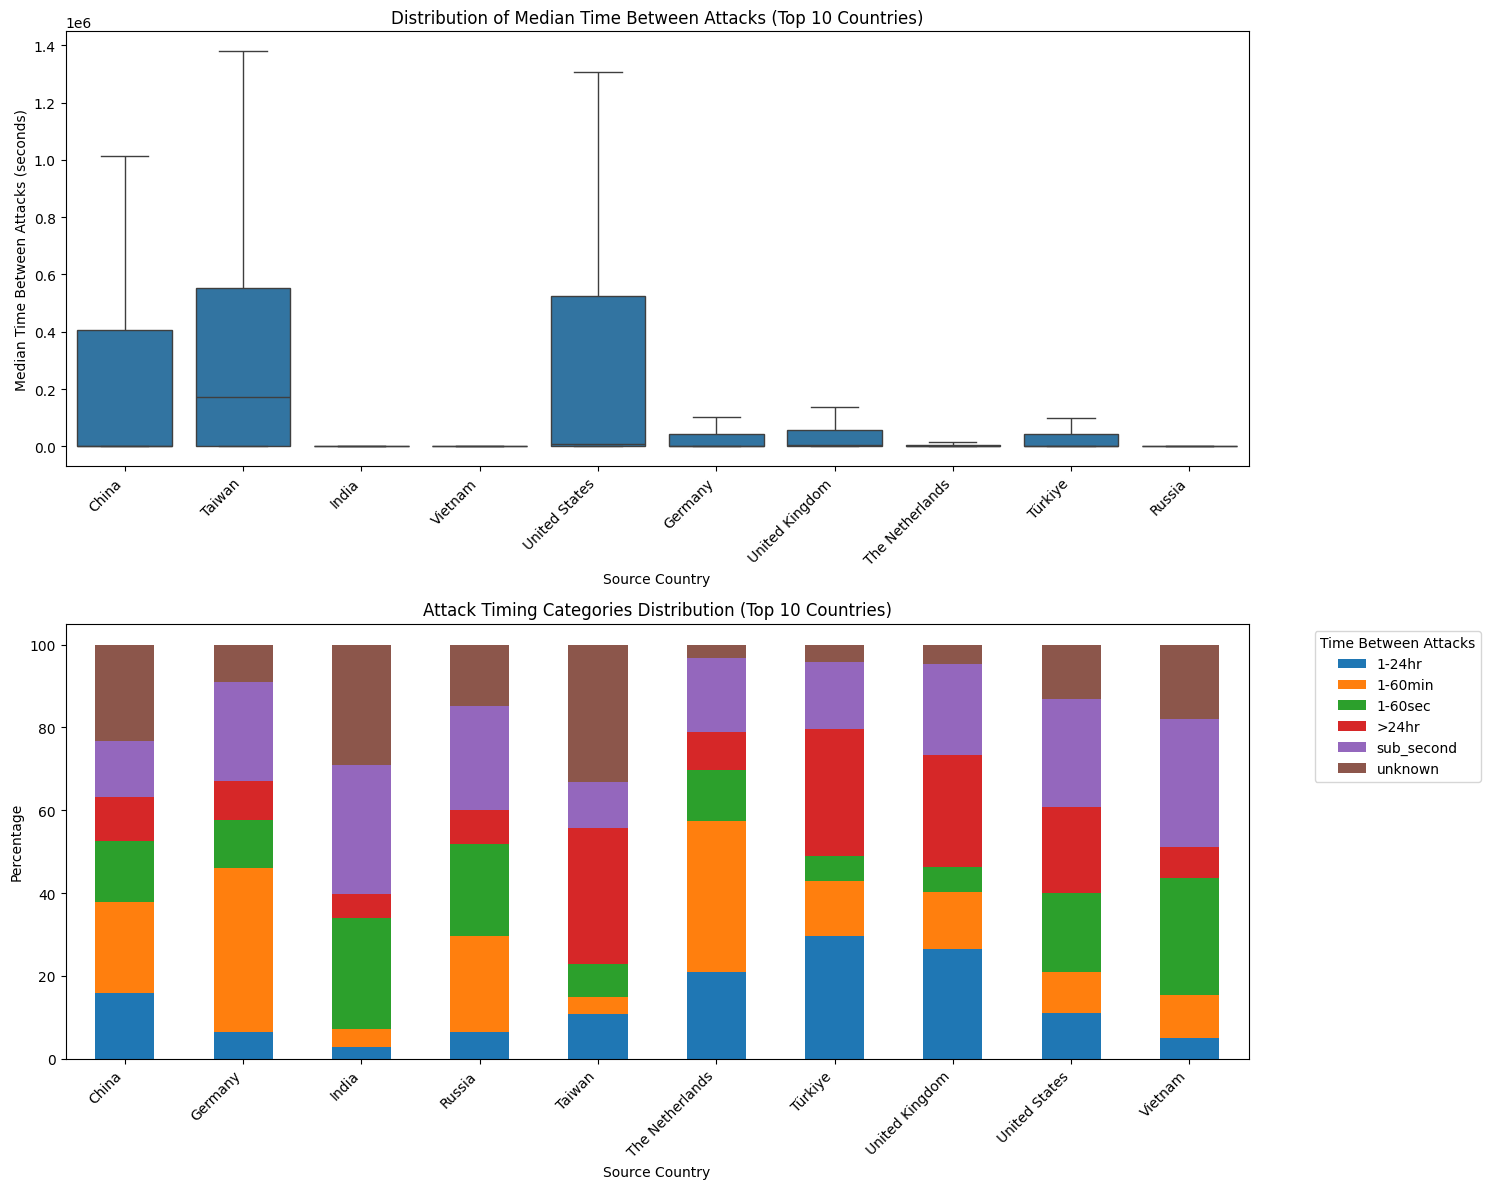


Summary Statistics for Top 10 Attacking Countries:
--------------------------------------------------

United States:
Total attacks: 130,309
Unique attackers: 17,160
Median time between attacks: 24.82 seconds
% of sub-second attacks: 26.1%

China:
Total attacks: 83,799
Unique attackers: 19,426
Median time between attacks: 881.85 seconds
% of sub-second attacks: 13.5%

India:
Total attacks: 47,560
Unique attackers: 13,853
Median time between attacks: 3.18 seconds
% of sub-second attacks: 31.0%

The Netherlands:
Total attacks: 41,832
Unique attackers: 1,381
Median time between attacks: 487.93 seconds
% of sub-second attacks: 17.9%

Russia:
Total attacks: 33,884
Unique attackers: 5,056
Median time between attacks: 12.85 seconds
% of sub-second attacks: 25.0%

United Kingdom:
Total attacks: 30,839
Unique attackers: 1,501
Median time between attacks: 15380.11 seconds
% of sub-second attacks: 21.9%

Türkiye:
Total attacks: 25,529
Unique attackers: 1,093
Median time between attacks: 31248.87

In [19]:
# Get top 10 attacking countries
top_10_countries = df['src_country'].value_counts().head(10).index

# Filter data for top 10 countries
df_top10 = df_sorted[df_sorted['src_country'].isin(top_10_countries)]

# Calculate stats for top 10 countries
time_stats_top10 = df_top10.groupby(['src_ip', 'src_country'])['time_diff'].agg(['median', 'count']).reset_index()
country_stats_top10 = time_stats_top10.groupby('src_country').agg({
    'median': ['mean', 'std'],
    'count': 'sum'
}).reset_index()

# Create visualizations
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Box plot for top 10 countries
sns.boxplot(data=time_stats_top10, x='src_country', y='median', ax=ax1, showfliers=False)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_title('Distribution of Median Time Between Attacks (Top 10 Countries)')
ax1.set_xlabel('Source Country')
ax1.set_ylabel('Median Time Between Attacks (seconds)')

# Stacked bar plot for attack categories
time_categories_top10 = df_top10.groupby(['src_country', 'time_category']).size().unstack(fill_value=0)
time_categories_pct_top10 = time_categories_top10.div(time_categories_top10.sum(axis=1), axis=0) * 100
time_categories_pct_top10.plot(kind='bar', stacked=True, ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_title('Attack Timing Categories Distribution (Top 10 Countries)')
ax2.set_xlabel('Source Country')
ax2.set_ylabel('Percentage')
ax2.legend(title='Time Between Attacks', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics for Top 10 Attacking Countries:")
print("-" * 50)
for country in top_10_countries:
    country_data = df_top10[df_top10['src_country'] == country]
    print(f"\n{country}:")
    print(f"Total attacks: {len(country_data):,}")
    print(f"Unique attackers: {country_data['src_ip'].nunique():,}")
    print(f"Median time between attacks: {country_data['time_diff'].median():.2f} seconds")
    print(f"% of sub-second attacks: {(country_data['time_diff'] < 1).mean()*100:.1f}%")

### Sub-second (<1 second)

Attacks occurring less than 1 second apart
Usually indicates automated/bot attacks or DDoS attempts
Very high frequency, machine-generated traffic

### 1-60 seconds
Attacks occurring between 1-60 seconds apart
Often indicates automated scanning or systematic probing
Still too fast for human operation

### 1-60 minutes
Attacks occurring between 1-60 minutes apart
Could be both automated (with delays) or human-driven
May indicate more sophisticated scanning with rate limiting

### 1-24 hours
Attacks occurring between 1-24 hours apart
More likely to be human-driven or scheduled automated tasks
Could indicate daily routines or scheduled scans

### >24 hours
Attacks occurring more than 24 hours apart
Usually indicates sporadic attempts or long-term reconnaissance
More likely to be human-driven or opportunistic attacks

# 4. Port Scanning Behavior
Analyzed port scanning patterns by looking at:
- Sequential port access
- Port range coverage
- Standard deviation of port numbers

In [ ]:
def has_sequential_ports(ports):
    ports_sorted = np.sort(ports)
    return int(np.any(np.diff(ports_sorted) == 1))

port_patterns = df.groupby('src_ip').agg(
    sequential_ports = ('dst_port', has_sequential_ports),
    port_range = ('dst_port', lambda x: x.max() - x.min())
    ).reset_index()

df = df.merge(port_patterns, on='src_ip', how='left')


# 5. Statistical Features
Added entropy and geographic spread metrics to help identify:
- Randomness in port selection
- Target distribution patterns
- Automated vs. human behavior patterns

In [21]:
df['attack_entropy'] = df.groupby('src_ip')['dst_port'].transform(lambda x: -sum([(v/len(x)) * np.log2(v/len(x)) 
                                                                                  for v in x.value_counts(normalize=True)]))
df['target_country_diversity'] = df.groupby('src_ip')['dst_country'].transform('nunique')
df['target_city_diversity'] = df.groupby('src_ip')['dst_city'].transform('nunique')
df['country_attack_concentration'] = df.groupby(['src_ip', 'dst_country']).cumcount() / \
                                    df.groupby('src_ip')['dst_country'].transform('count')
print("\nGeographic Feature Statistics:")
print(df[['target_country_diversity', 'target_city_diversity', 
         'country_attack_concentration']].describe())


Geographic Feature Statistics:
       target_country_diversity  target_city_diversity  \
count             675083.000000          675083.000000   
mean                   5.775155               9.055288   
std                    6.034710              11.171424   
min                    1.000000               1.000000   
25%                    1.000000               1.000000   
50%                    3.000000               3.000000   
75%                    9.000000              12.000000   
max                   18.000000              39.000000   

       country_attack_concentration  
count                 675083.000000  
mean                       0.191511  
std                        0.239667  
min                        0.000000  
25%                        0.000000  
50%                        0.083333  
75%                        0.304348  
max                        0.998291  


# Protocol-Level Analysis and Attack Patterns

This section analyzes protocol-specific patterns in attacks to identify:
- Protocol-specific vulnerabilities
- Common attack vectors
- Service targeting patterns

In [22]:
protocol_categories = {
    'web': ['http', 'https'],
    'file_transfer': ['ftp', 'smb'],
    'remote_access': ['ssh', 'telnet', 'rdp', 'vnc', 'teamviewer', 'mikrotik'],
    'email': ['smtp', 'smtps', 'imap', 'imaps', 'pop3', 'pop3s'],
    'database': ['redis', 'mongodb', 'memcached', 'elasticsearch'],
    'messaging': ['mqtt', 'mqtts', 'amqp', 'amqps'],
    'vpn': ['openvpn'],
    'iot': ['tr-069', 'hisilicon'],
    'other': ['other']
}

inv_protocol_categories = {el: k for k, lst in protocol_categories.items() for el in lst}

df["protocol_category"] = df["protocol"].apply(lambda x: inv_protocol_categories[x])

In [23]:
import numpy as np

# Functions
def calculate_burstiness(timestamps):
    if len(timestamps) < 2:
        return 0
    intervals = np.diff(timestamps)
    mean_interval = np.mean(intervals)
    std_interval = np.std(intervals)
    return (std_interval / mean_interval) if mean_interval > 0 else 0

def calculate_periodicity(timestamps):
    if len(timestamps) < 2:
        return 0
    intervals = np.diff(timestamps)
    return (np.std(intervals) < 1e-3) * 1  # 1 = very periodic, 0 = not

# Group and calculate metrics
attack_metrics = []

for ip, group in df.groupby('src_ip'):
    times = group['timestamp'].sort_values().astype(np.int64) / 1e9  # convert to seconds
    burstiness = calculate_burstiness(times)
    periodicity = calculate_periodicity(times)
    port_diversity = group['dst_port'].nunique()
    target_diversity = group['dst_ip'].nunique()

    attack_metrics.append({
        'src_ip': ip,
        'burstiness': burstiness,
        'periodicity': periodicity,
        'port_diversity': port_diversity,
        'target_diversity': target_diversity
    })

attack_patterns = pd.DataFrame(attack_metrics).set_index('src_ip')

periodic_ips = attack_patterns[attack_patterns['periodicity'] == 1]
print(f"Highly periodic attackers: {len(periodic_ips)}")
print(periodic_ips.head())


Highly periodic attackers: 14367
             burstiness  periodicity  port_diversity  target_diversity
src_ip                                                                
1.0.104.204         0.0            1               1                 2
1.0.218.2           0.0            1               1                 1
1.0.218.22          0.0            1               1                 1
1.0.254.128         0.0            1               1                 1
1.10.223.3          0.0            1               1                 2


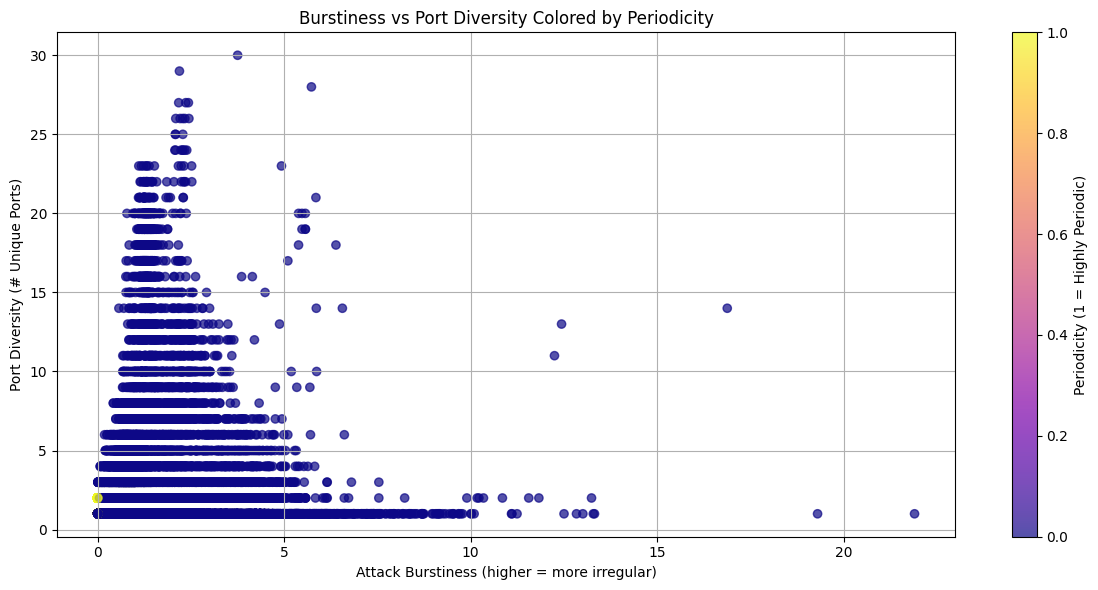

In [24]:
plt.figure(figsize=(12, 6))
sc = plt.scatter(
    attack_patterns['burstiness'],
    attack_patterns['port_diversity'],
    c=attack_patterns['periodicity'],
    cmap='plasma', alpha=0.7
)

plt.colorbar(sc, label='Periodicity (1 = Highly Periodic)')
plt.xlabel('Attack Burstiness (higher = more irregular)')
plt.ylabel('Port Diversity (# Unique Ports)')
plt.title('Burstiness vs Port Diversity Colored by Periodicity')
plt.grid(True)
plt.tight_layout()
plt.show()


# Entropy and N-gram Analysis

This section analyzes payload entropy and n-gram patterns to identify:
- Potential command injection attacks
- Encoded/encrypted payloads
- Common attack signatures

In [25]:
from scipy.stats import entropy

def get_payload_features(payload):
    default = {'length': 0, 'unique_bytes': 0, 'entropy': 0.0,
               'mean_byte': 0.0, 'std_byte': 0.0}
    if not isinstance(payload, str) or len(payload) == 0:
        return default
    try:
        data = bytes.fromhex(payload)
    except ValueError:
        return default
    length = len(data)
    if length == 0:
        return default
    arr = np.frombuffer(data, dtype=np.uint8)
    counts = np.bincount(arr, minlength=256)
    probs = counts / length

    probs = probs[probs > 0]
    ent = entropy(probs, base=2)
    mean = float(arr.mean())
    std = float(arr.std())
    return {
        'length': length,
        'unique_bytes': int(np.count_nonzero(counts)),
        'entropy': float(ent),
        'mean_byte': mean,
        'std_byte': std
    }

payload_feats = ['pl_length', 'pl_unique_bytes', 'pl_entropy', 'pl_mean_byte', 'pl_std_byte']
df[payload_feats] = df["payload_4kb_hex"].apply(get_payload_features).apply(pd.Series)

In [26]:
def decode_payload(hex_str: str, protocol: str) -> str:
    if not hex_str or not isinstance(hex_str, str):
        return ""
    
    try:
        raw_bytes = bytes.fromhex(hex_str)
        if not raw_bytes:
            return ""

        # SSH 
        if protocol == 'ssh':
            # Clean SSH banners
            if raw_bytes.startswith(b'SSH-'):
                banner = raw_bytes.decode('utf-8', errors='ignore').split('\n')[0]
                return banner.strip()
            
            # Detect HTTP requests on SSH port
            if raw_bytes.startswith((b'GET ', b'POST ', b'HEAD ', b'PUT ')):
                try:
                    return "HTTP_OVER_SSH: " + raw_bytes.decode('utf-8').split('\r\n')[0]
                except:
                    return "HTTP_OVER_SSH_BINARY"
            
            # Detect binary commands
            try:
                text = raw_bytes.decode('utf-8', errors='ignore')
                if any(cmd in text.lower() for cmd in ['wget', 'curl', 'chmod', 'sh -c']):
                    return "SSH_CMD: " + ' '.join(text.split())[:200]
            except:
                pass
            
            return f"SSH_BINARY_{len(raw_bytes)}B"

        # HTTP/HTTPS
        elif protocol in ['http', 'https']:
            # Reject SSH banners in HTTP
            if raw_bytes.startswith(b'SSH-'):
                return "SSH_OVER_HTTP"
            
            # Handle valid HTTP
            if raw_bytes.startswith((b'GET ', b'POST ', b'HEAD ', b'PUT ')):
                try:
                    first_line = raw_bytes.decode('utf-8').split('\r\n')[0]
                    return f"HTTP: {first_line}"
                except:
                    return "HTTP_BINARY"
            
            # Handle SSL/TLS
            if len(raw_bytes) > 0 and raw_bytes[0] == 0x16:
                return "SSL_HANDSHAKE"
            
            # Other cases
            try:
                text = raw_bytes.decode('utf-8', errors='ignore')
                if text.strip():
                    return f"HTTP_TEXT: {text[:200]}"
            except:
                pass
            
            return f"HTTP_BINARY_{len(raw_bytes)}B"

        # SMB 
        elif protocol == 'smb':
            if len(raw_bytes) > 8:
                # SMB command mapping
                smb_commands = {
                    0x00: "SMB_NEGOTIATE",
                    0x73: "SMB_NEGOTIATE",  # Common variant
                    0x75: "SMB_TREE_CONNECT",
                    0x1d: "SMB_SESSION_SETUP",
                    0x25: "SMB_CREATE",
                    0x2e: "SMB_IOCTL",
                    0x32: "SMB_READ",
                    0x0b: "SMB_TREE_DISCONNECT"
                }
                cmd = smb_commands.get(raw_bytes[4], f"SMB_UNKNOWN_{raw_bytes[4]}")
                return cmd if cmd != "SMB_NEGOTIATE" or raw_bytes[4:8] == b'\xffSMB' else "SMB_INVALID"
            return "SMB_EMPTY"

        # Other Protocols 
        else:
            try:
                text = raw_bytes.decode('utf-8', errors='ignore')
                if text.strip():
                    return f"{protocol}_TEXT: {text[:200]}"
            except:
                pass
            return f"{protocol}_BINARY_{len(raw_bytes)}B"

    except Exception as e:
        return f"DECODE_ERROR_{str(e)}"

# Reapply decoding
df['payload_decoded'] = df.apply(
    lambda row: decode_payload(row['payload_4kb_hex'], row['protocol']), 
    axis=1
)

In [27]:
print("=== SSH Payloads ===")
print(df[df['protocol'] == 'ssh']['payload_decoded'].head(5).to_string())

print("\n=== HTTP Payloads ===")
print(df[df['protocol'] == 'http']['payload_decoded'].head(5).to_string())

print("\n=== SMB Payloads ===")
print(df[df['protocol'] == 'smb']['payload_decoded'].head(5).to_string())

=== SSH Payloads ===
2     HTTP_OVER_SSH: GET / HTTP/1.1
4     HTTP_OVER_SSH: GET / HTTP/1.1
21                                 
36                                 
78                       SSH-2.0-Go

=== HTTP Payloads ===
7                 SSL_HANDSHAKE
10    HTTP: GET /hello HTTP/1.1
19    HTTP: GET /hello HTTP/1.1
22                SSL_HANDSHAKE
24         HTTP: GET / HTTP/1.1

=== SMB Payloads ===
0     SMB_UNKNOWN_191
3     SMB_UNKNOWN_239
5                    
11                   
12    SMB_UNKNOWN_191


In [28]:
# binary feature if a command is present in an attack
commands = ['wget', 'curl', 'chmod', 'dd', 'http_over_ssh', 'scp', 'passwd', 'ftp', 'nc', 'ftp', 'tar', 'rm -rf']
for cmd in commands:
    df[f'cmd_{cmd}'] = df['payload_decoded'].str.contains(cmd, case=False).astype(int)


Payload Feature Summary Statistics:
                    count        mean         std  min  25%        50%  \
pl_length        675083.0  122.234552  256.946602  0.0  0.0  44.000000   
pl_unique_bytes  675083.0   25.959558   31.458778  0.0  0.0  18.000000   
pl_entropy       675083.0    2.728396    1.977277  0.0  0.0   3.577677   
pl_mean_byte     675083.0   48.227639   39.777287  0.0  0.0  56.358025   
pl_std_byte      675083.0   38.404462   32.942755  0.0  0.0  32.265291   

                        75%          max  
pl_length        147.000000  6996.000000  
pl_unique_bytes   42.000000   227.000000  
pl_entropy         4.359443     6.059452  
pl_mean_byte      67.795918   206.333333  
pl_std_byte       61.277293   101.904501  


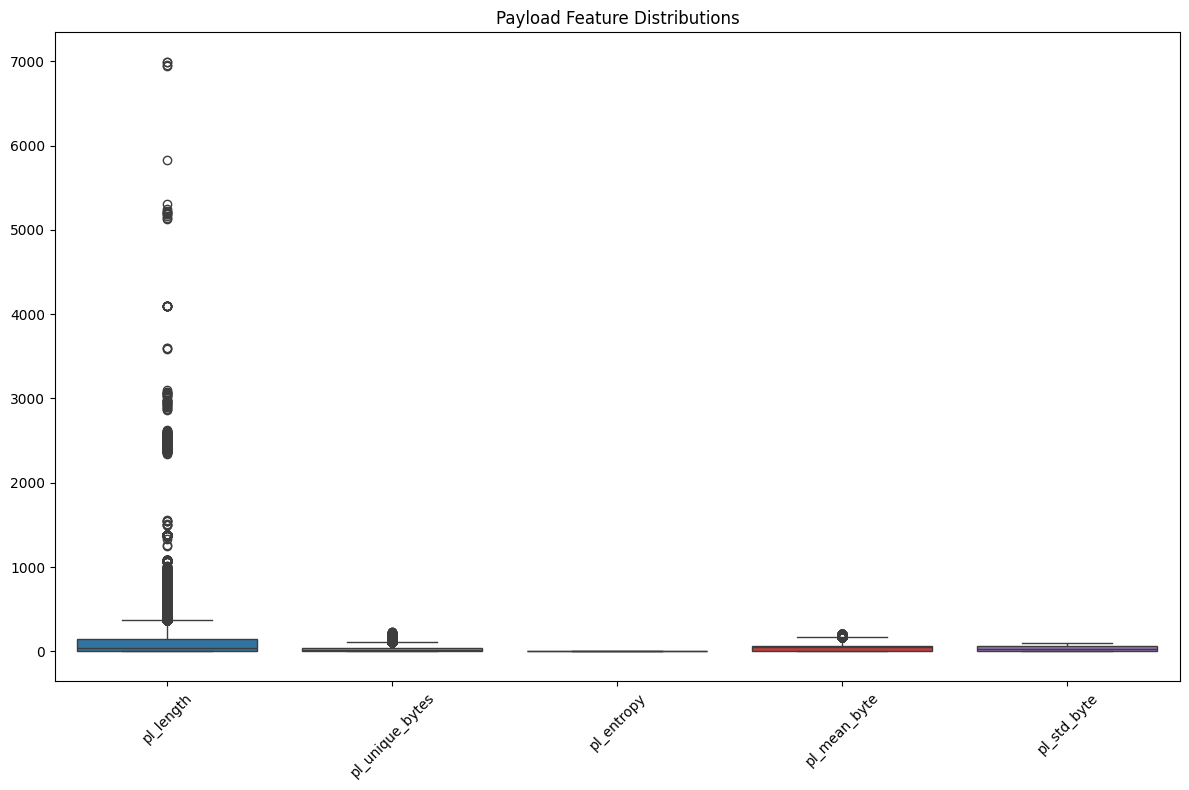

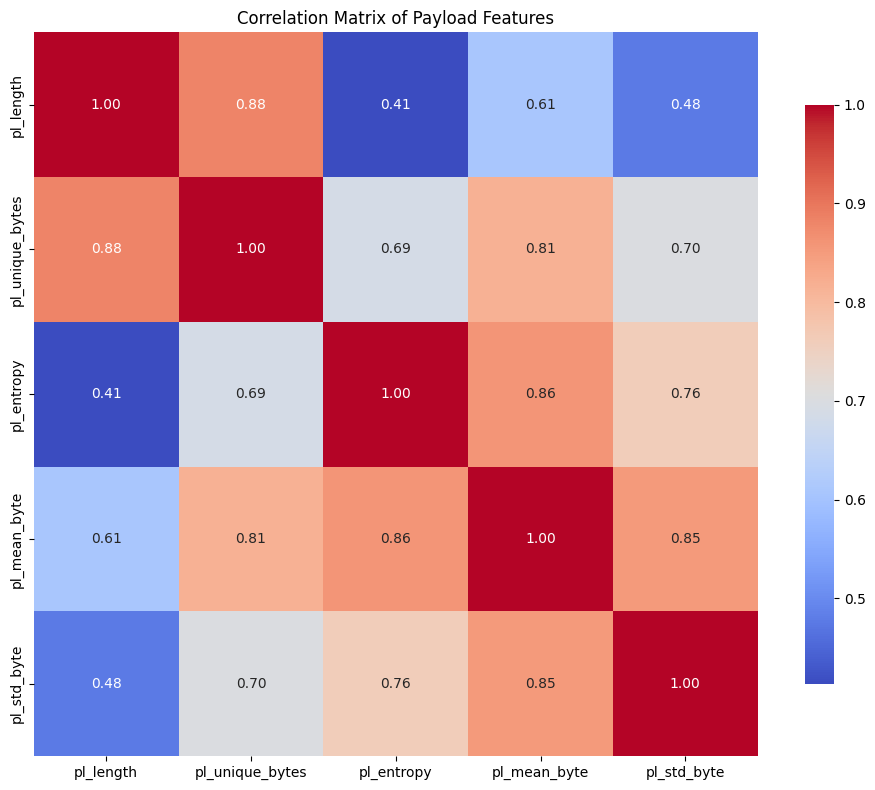

In [29]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[payload_feats])
plt.title('Payload Feature Distributions')
plt.xticks(rotation=45)
plt.tight_layout()

# Calculate correlation matrix for payload features
corr_matrix = df[payload_feats].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Payload Features')
plt.tight_layout()

# Print summary statistics for payload features
print("\nPayload Feature Summary Statistics:")
print(df[payload_feats].describe().T)

## Analysis of command features added 

In [30]:
df = df.drop(columns=['payload_4kb_hex'])
df.reset_index(drop=True, inplace=True)

cmd_nc               12804
cmd_ftp               4917
cmd_dd                3490
cmd_http_over_ssh     2125
cmd_curl              1267
cmd_scp                992
cmd_wget               394
cmd_tar                370
cmd_chmod              315
cmd_rm -rf              15
cmd_passwd              14
dtype: int64


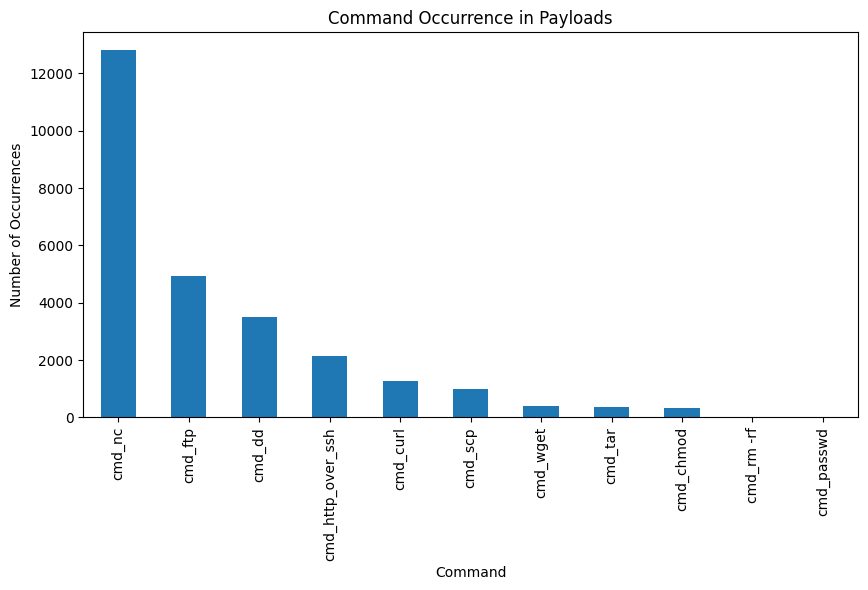

In [31]:
cmd_cols = [col for col in df.columns if col.startswith('cmd_')]
print(df[cmd_cols].sum().sort_values(ascending=False))


cmd_cols = [col for col in df.columns if col.startswith('cmd_')]
cmd_counts = df[cmd_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
cmd_counts.plot(kind='bar')
plt.title('Command Occurrence in Payloads')
plt.ylabel('Number of Occurrences')
plt.xlabel('Command')
plt.show()

In [32]:
df.isna().sum()

src_port      0
dst_port      0
timestamp     0
src_as        0
src_city      0
             ..
cmd_passwd    0
cmd_ftp       0
cmd_nc        0
cmd_tar       0
cmd_rm -rf    0
Length: 73, dtype: int64

# Text Embedding and Dimension Reduction

Process textual data:
- protocol encoding
- City name embeddings
- PCA dimension reduction
- Feature matrix preparation

In [33]:
ohe = OneHotEncoder(drop='first', handle_unknown="ignore").fit(df[["protocol_category"]])

df[ohe.get_feature_names_out()] = ohe.transform(df[["protocol_category"]]).toarray().astype(int)
df.drop(columns=["protocol_category", "protocol"], inplace=True)

In [34]:
model = SentenceTransformer('all-MiniLM-L6-v2')
src_city_embeddings = model.encode(df['src_city'].astype(str).tolist())
dst_city_embeddings = model.encode(df['dst_city'].astype(str).tolist())
src_country_embeddings = model.encode(df['src_country'].astype(str).tolist())
dst_country_embeddings = model.encode(df['dst_country'].astype(str).tolist())

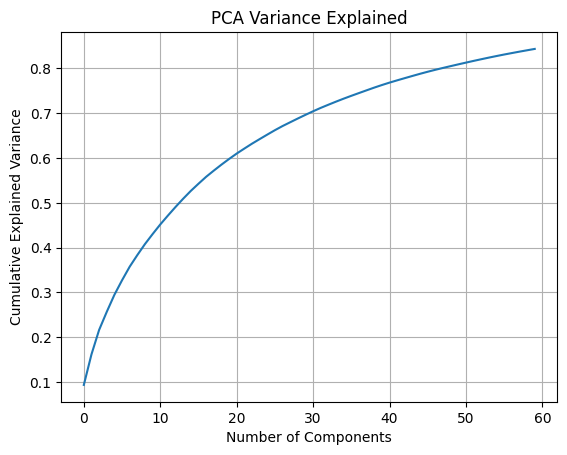

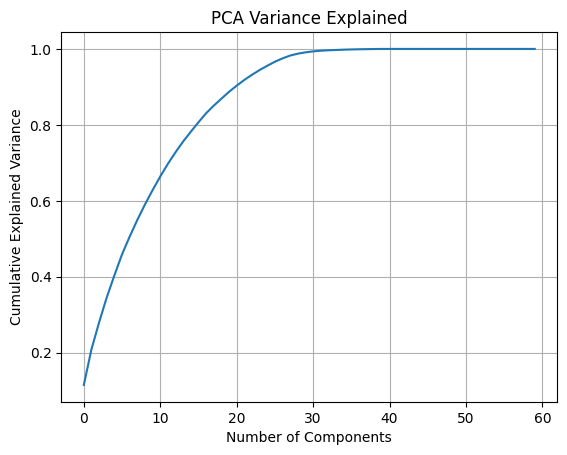

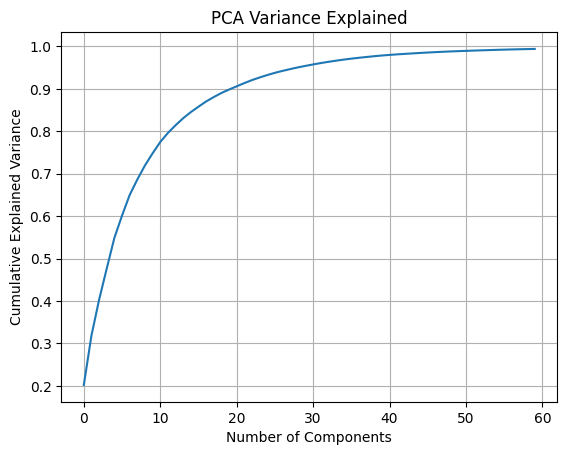

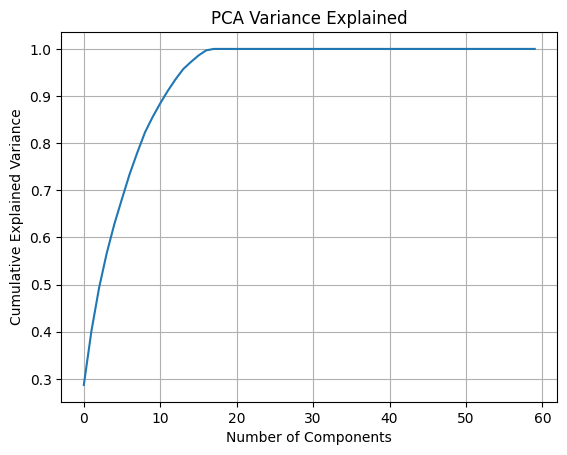

In [35]:
pca_full = PCA().fit(src_city_embeddings)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
plt.plot(cumulative_variance[:60])
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Variance Explained')
plt.grid(True)
plt.show()

pca_full = PCA().fit(dst_city_embeddings)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
plt.plot(cumulative_variance[:60])
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Variance Explained')
plt.grid(True)
plt.show()

pca_full = PCA().fit(src_country_embeddings)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
plt.plot(cumulative_variance[:60])
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Variance Explained')
plt.grid(True)
plt.show()

pca_full = PCA().fit(dst_country_embeddings)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
plt.plot(cumulative_variance[:60])
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Variance Explained')
plt.grid(True)
plt.show()

In [36]:
n_components = 23
pca = PCA(n_components=n_components)
src_city_emb_reduced = pca.fit_transform(src_city_embeddings)

explained_variance_ratio = pca.explained_variance_ratio_
total_variance = explained_variance_ratio.sum()

n_components = 19
pca = PCA(n_components=n_components)
dst_city_emb_reduced = pca.fit_transform(dst_city_embeddings)
explained_variance_ratio = pca.explained_variance_ratio_
total_variance = explained_variance_ratio.sum()

n_components = 19
pca = PCA(n_components=n_components)
src_country_emb_reduced = pca.fit_transform(src_country_embeddings)
explained_variance_ratio = pca.explained_variance_ratio_
total_variance = explained_variance_ratio.sum()

n_components = 10
pca = PCA(n_components=n_components)
dst_country_emb_reduced = pca.fit_transform(dst_country_embeddings)
explained_variance_ratio = pca.explained_variance_ratio_
total_variance = explained_variance_ratio.sum()

In [37]:
city_emb_cols = [f"src_city_emb_{i}" for i in range(src_city_emb_reduced.shape[1])]
city_emb_df = pd.DataFrame(src_city_emb_reduced, columns=city_emb_cols, index=df.index)
df = pd.concat([df, city_emb_df], axis=1)


city_emb_cols = [f"dst_city_emb_{i}" for i in range(dst_city_emb_reduced.shape[1])]
city_emb_df = pd.DataFrame(dst_city_emb_reduced, columns=city_emb_cols, index=df.index)
df = pd.concat([df, city_emb_df], axis=1)

country_emb_cols = [f"src_country_emb_{i}" for i in range(src_country_emb_reduced.shape[1])]
country_emb_df = pd.DataFrame(src_country_emb_reduced, columns=country_emb_cols, index=df.index)
df = pd.concat([df, country_emb_df], axis=1)

country_emb_cols = [f"dst_country_emb_{i}" for i in range(dst_country_emb_reduced.shape[1])]
country_emb_df = pd.DataFrame(dst_country_emb_reduced, columns=country_emb_cols, index=df.index)
df = pd.concat([df, country_emb_df], axis=1)

In [11]:
with open('data/processed_data.pkl', 'wb') as f:
    pickle.dump(df, f)

# Categorical Feature Encoding

We'll encode our categorical features using appropriate techniques:
- One-hot encoding for nominal categories with few unique values
- Target encoding for high-cardinality features
- Frequency encoding for location-based features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime, timezone
import ipaddress
from collections import Counter

from tqdm import tqdm
import plotly.express as px

from sentence_transformers import SentenceTransformer
import hdbscan

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.utils import resample
from sklearn.metrics import (
    silhouette_score as sil_,
    silhouette_samples,
    calinski_harabasz_score as calinski_,
)
from yellowbrick.cluster import SilhouetteVisualizer
import pickle
import umap

C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('data/processed_data.pkl', 'rb') as f:
    df = pickle.load(f)
df.reset_index(drop=True, inplace=True)

In [3]:
df.replace({True: 1, False: 0}, inplace=True)

C:\Users\luca.lucchina\AppData\Local\Temp\ipykernel_3064\3673826116.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0}, inplace=True)


encode the AS based on the number of rows it is used in

In [4]:
num_unique_as = df['src_as'].nunique()
as_freq = df['src_as'].value_counts().to_dict()
df['src_as_encoded'] = df['src_as'].map(as_freq)
num_unique_as  

6525

In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed', errors='coerce')

df['minute'] = df['timestamp'].dt.minute
df["second"] = df['timestamp'].dt.second

In [6]:
df.drop(columns=["protocol_category", 'src_local_hour', 'dst_local_hour', "timestamp", "src_local_time", "dst_local_time", 'src_ip', 'dst_ip', "src_as", "dst_as", "src_city", "dst_city", "src_country", "dst_country", "src_timezone", "dst_timezone", "src_regionName", "dst_regionName", "src_countryCode", "dst_countryCode", "protocol", "payload_decoded"], inplace=True, errors='ignore')


Missing values after preprocessing:
Empty DataFrame
Columns: [missing_count]
Index: []


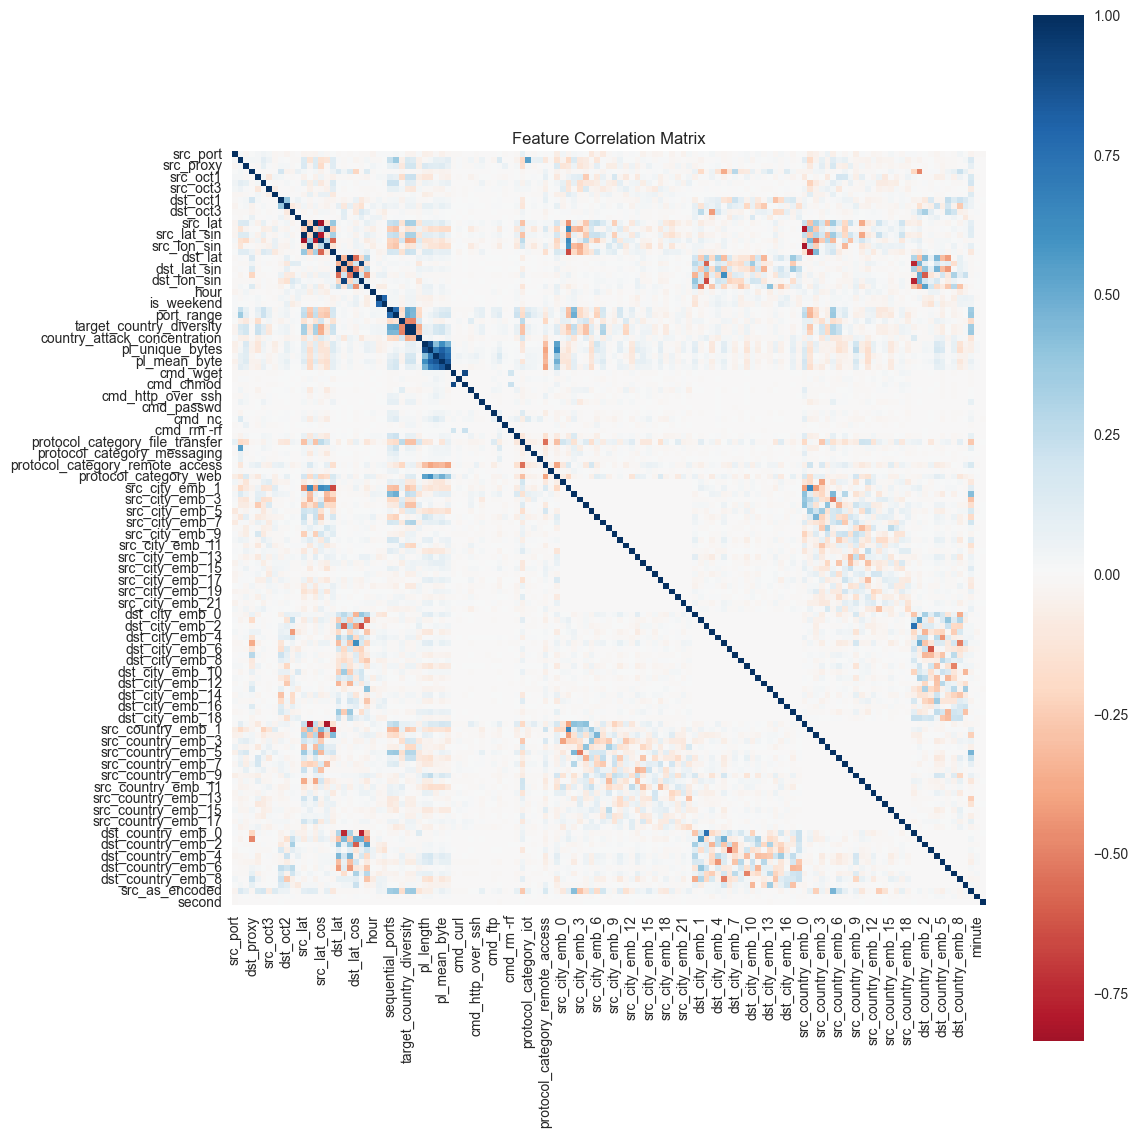

In [7]:
X = df.copy()

# Handle missing values with appropriate strategies
for col in X.columns:
    if X[col].dtype in ['int64', 'float64']:
        if 'ratio' in col:
            # For ratio features, fill with 0
            X[col] = X[col].fillna(0)
        else:
            # For other numeric features, fill with median
            X[col] = X[col].fillna(X[col].median())

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Check for any remaining missing values
print('\nMissing values after preprocessing:')
print(pd.DataFrame({'missing_count': X.isna().sum()[X.isna().sum() > 0]}))

# Feature correlation analysis
plt.figure(figsize=(12, 12))
sns.heatmap(X.corr(), center=0, cmap='RdBu', square=True)
plt.title('Feature Correlation Matrix')
plt.tight_layout()

# 6. Advanced Attack Pattern Clustering

This section uses sophisticated clustering techniques to identify:
- Geographic attack patterns
- Temporal attack clusters
- Protocol behavior patterns
- Attack campaign fingerprints

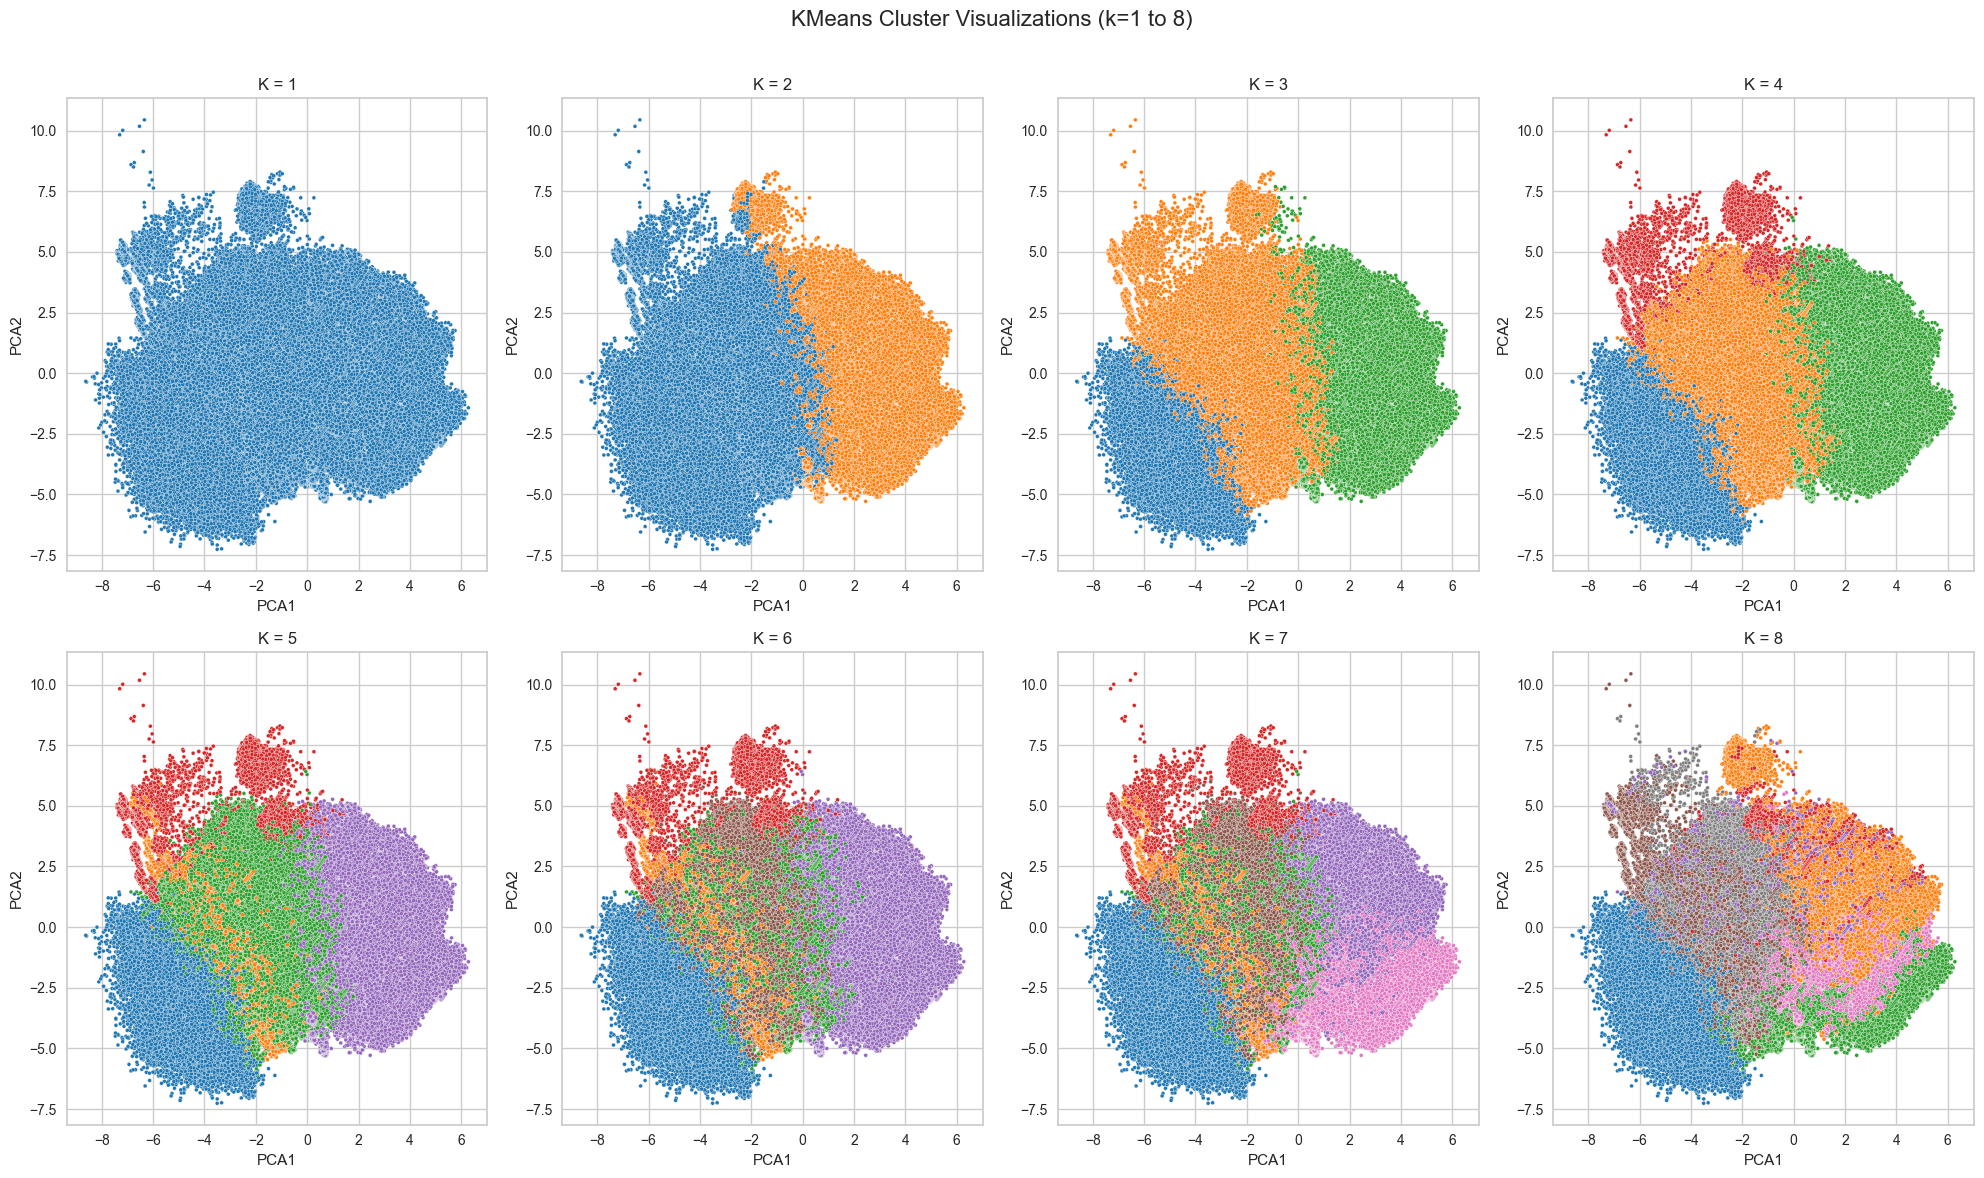

In [8]:
pca = PCA(n_components=2)


X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(2, 4, figsize=(20, 12))
axes = axes.flatten()

for i, k in enumerate(range(1, 9)):
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(X_scaled)

    sns.scatterplot(
        x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, 
        palette='tab10', ax=axes[i], legend=False, s=8
    )
    axes[i].set_title(f'K = {k}')
    axes[i].set_xlabel('PCA1')
    axes[i].set_ylabel('PCA2')


plt.suptitle('KMeans Cluster Visualizations (k=1 to 8)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [ ]:
pca = umap.UMAP()

X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(2, 4, figsize=(20, 12))
axes = axes.flatten()

for i, k in enumerate(range(1, 9)):
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(X_scaled)

    sns.scatterplot(
        x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, 
        palette='tab10', ax=axes[i], legend=False, s=8
    )
    axes[i].set_title(f'K = {k}')
    axes[i].set_xlabel('PCA1')
    axes[i].set_ylabel('PCA2')


plt.suptitle('KMeans Cluster Visualizations (k=1 to 8)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [ ]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=1000,
    min_samples=50,
    cluster_selection_epsilon=0.15,
    approx_min_span_tree=False
)

cluster_labels = clusterer.fit_predict(X_scaled)

df['attack_cluster'] = cluster_labels

print("Cluster sizes:")
pd.Series(cluster_labels).value_counts().sort_index()

C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Cluster sizes:
-1     325114
 0      25272
 1       1489
 2       3390
 3       7696
        ...  
 57      2702
 58      1109
 59      1898
 60      2453
 61      6065
Name: count, Length: 63, dtype: int64


## Clustering Analysis

Apply clustering algorithms and analyze results:
- Cluster visualization
- silhouette score
- Pattern analysis by cluster of the features 

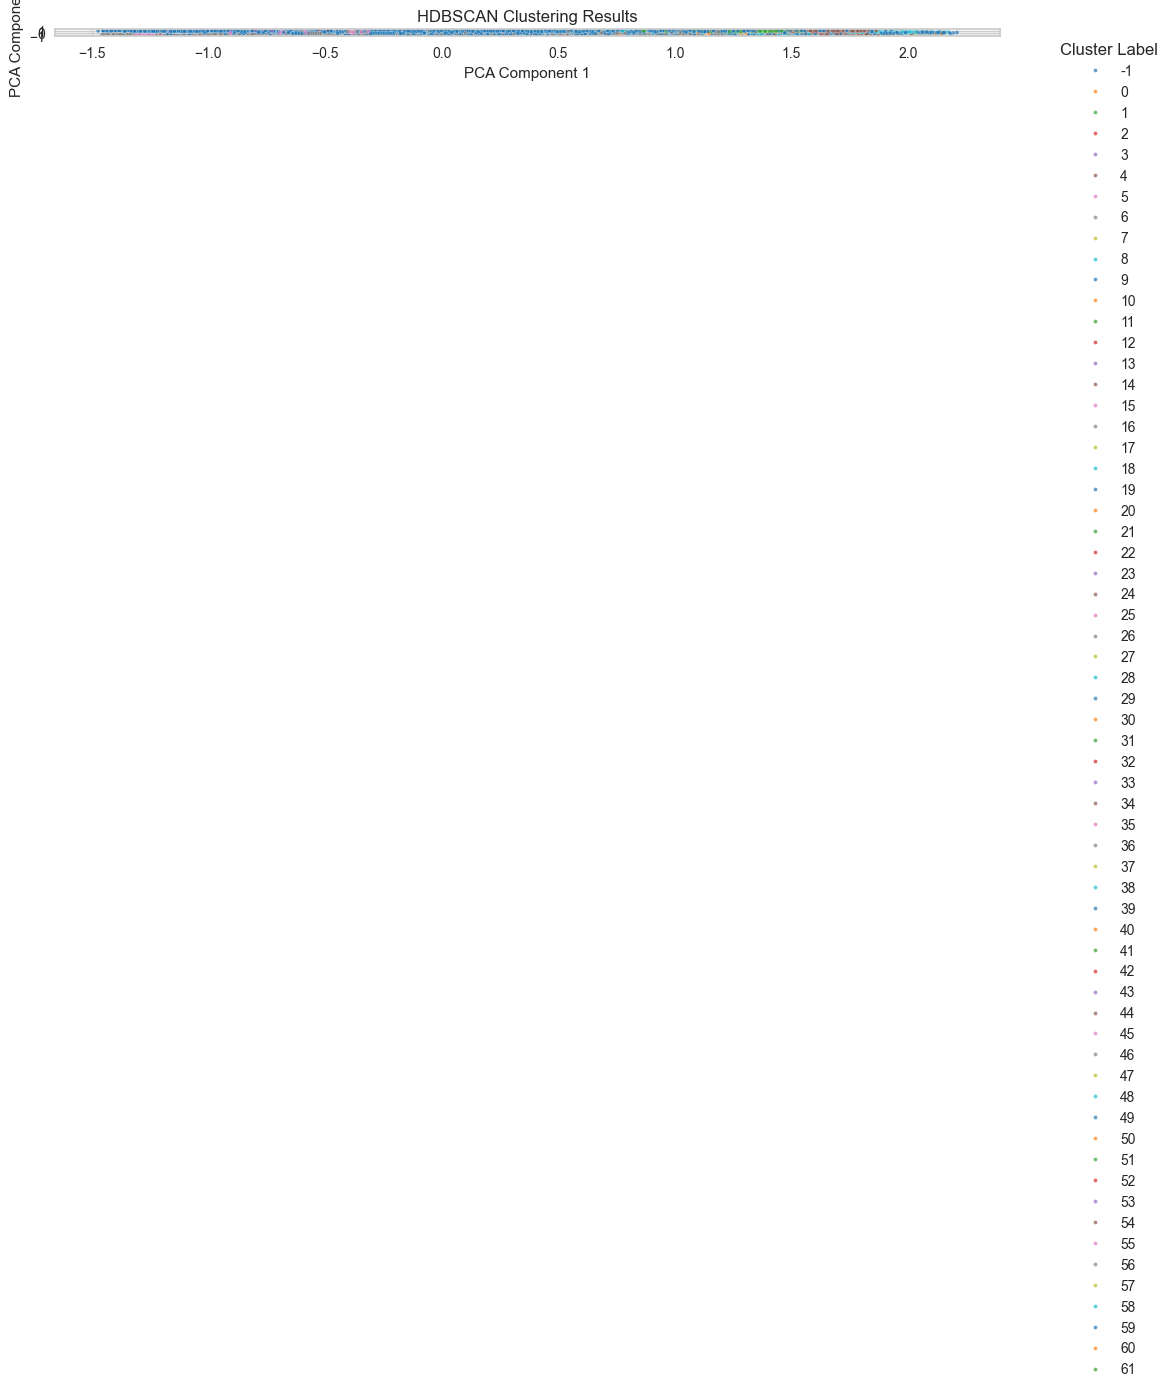

In [ ]:
pca_vis = PCA(n_components=2)
X_vis = pca_vis.fit_transform(X_scaled)
# Plot with noise
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=X_vis[:, 0], y=X_vis[:, 1], hue=cluster_labels, 
    palette='tab10', s=8, legend='full', alpha=0.7
)
plt.title('HDBSCAN Clustering Results')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

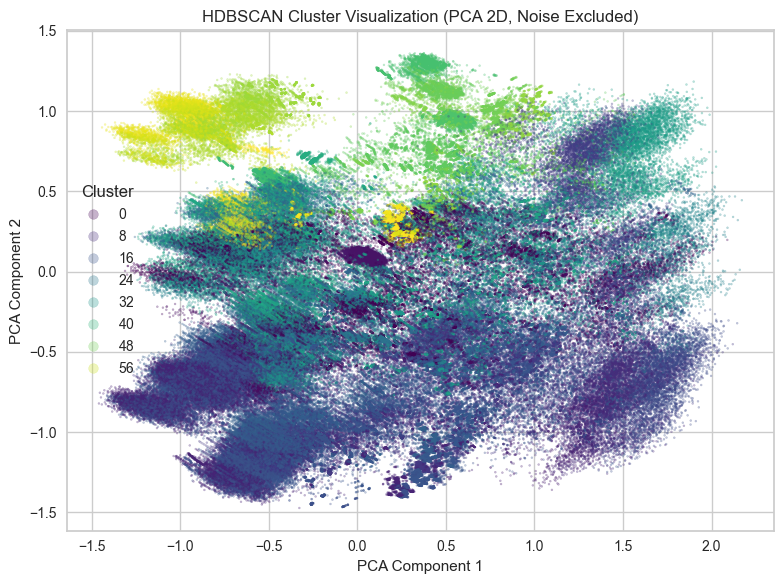

In [11]:
mask = cluster_labels != -1
X_vis_filtered = X_vis[mask]
cluster_labels_filtered = cluster_labels[mask]

# Plot without noise
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_vis_filtered[:, 0], X_vis_filtered[:, 1],
    c=cluster_labels_filtered, cmap='viridis', alpha=0.3, s=2
)
plt.title("HDBSCAN Cluster Visualization (PCA 2D, Noise Excluded)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.tight_layout()
plt.show()

In [12]:
cluster_means = df[df['attack_cluster'] != -1].groupby('attack_cluster').mean(numeric_only=True)
print(cluster_means)

                    src_port     dst_port  src_proxy  dst_proxy    src_oct1  \
attack_cluster                                                                
0               45927.570750  1822.977485   0.103514   0.000000  129.025087   
1               48487.200134  1693.231028   0.000000   0.000000  122.625923   
2               48571.605900   399.161062   0.115929   0.000000  123.541298   
3               37317.613176   443.000000   0.000000   0.000000   45.418529   
4               36666.266667   443.000000   0.000000   0.000000   29.040705   
...                      ...          ...        ...        ...         ...   
57              53430.685418   441.489267   0.000000   0.000000  105.848261   
58              37272.214608    22.000000   0.102795   0.839495  217.965735   
59              53304.499473   444.355111   0.000000   0.000000  101.820337   
60              40748.028944    28.517733   0.010599   0.000000  179.657562   
61              41504.828689   197.401979   0.000000

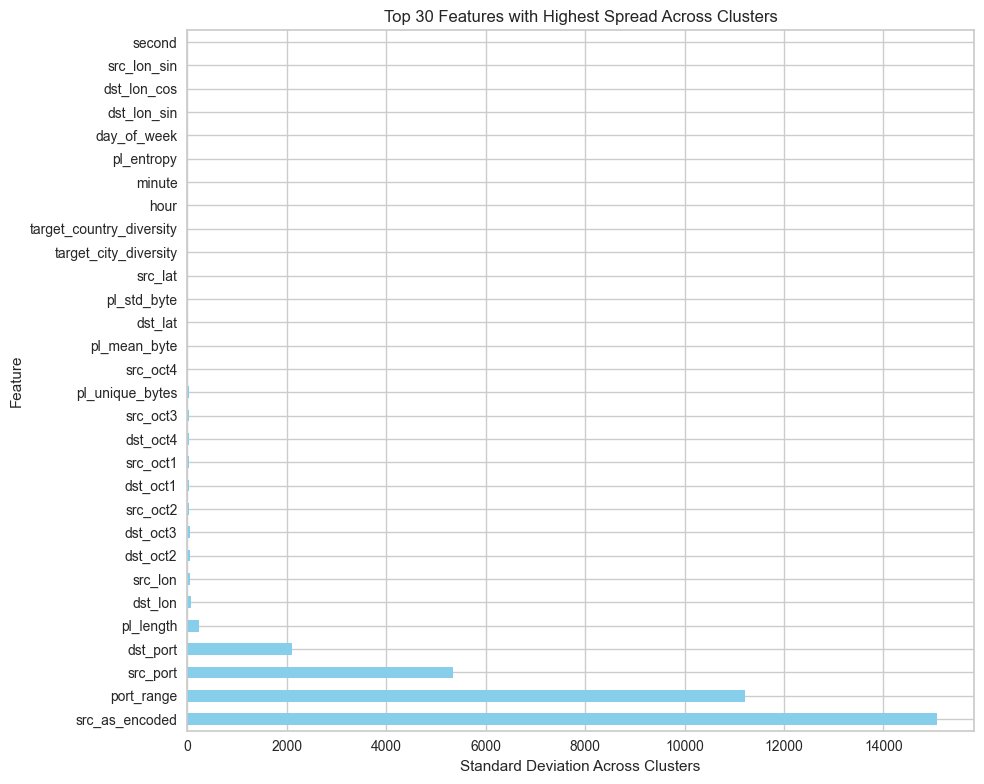

src_as_encoded              15066.463848
port_range                  11222.568521
src_port                     5341.188447
dst_port                     2117.323275
pl_length                     229.266455
dst_lon                        80.400312
src_lon                        59.355404
dst_oct2                       53.877773
dst_oct3                       49.485777
src_oct2                       47.013909
dst_oct1                       44.855969
src_oct1                       37.666544
dst_oct4                       35.811845
src_oct3                       31.674679
pl_unique_bytes                28.451024
src_oct4                       25.243873
pl_mean_byte                   24.831833
dst_lat                        22.648268
pl_std_byte                    20.392287
src_lat                        15.982848
target_city_diversity          10.315809
target_country_diversity        5.715591
hour                            3.396880
minute                          2.283344
pl_entropy      

In [ ]:
cluster_means_T = cluster_means.T
feature_spread = cluster_means_T.std(axis=1).sort_values(ascending=False)

top_n = 30
top_features = feature_spread.head(top_n)

top_features 


## Silhouette score

In [16]:
mask = cluster_labels != -1
X_filtered = X_scaled[mask]
labels_filtered = cluster_labels[mask]

# Compute silhouette scores
silhouette_vals = silhouette_samples(X_filtered, labels_filtered)
avg_silhouette = sil_(X_filtered, labels_filtered)

# Sort for better visualization
sorted_idx = np.argsort(labels_filtered)
sorted_silhouette_vals = silhouette_vals[sorted_idx]
sorted_cluster_labels = labels_filtered[sorted_idx]

# Create silhouette plot
fig, ax = plt.subplots(figsize=(10, 6))
y_lower = 10
unique_labels = np.unique(labels_filtered)

for label in unique_labels:
    label_sil_vals = sorted_silhouette_vals[sorted_cluster_labels == label]
    label_sil_vals.sort()
    y_upper = y_lower + len(label_sil_vals)

    color = plt.cm.viridis(float(label) / (len(unique_labels) - 1))
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, label_sil_vals, facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * len(label_sil_vals), f'Cluster {label}')
    y_lower = y_upper + 10

# Draw average silhouette score line
ax.axvline(avg_silhouette, color="red", linestyle="--", label=f"Avg Silhouette = {avg_silhouette:.2f}")
ax.set_title("Silhouette Plot for HDBSCAN Clusters (Excluding Noise)")
ax.set_xlabel("Silhouette Coefficient Values")
ax.set_ylabel("Cluster Label")
ax.legend()
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

# Grouped dataset creation

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime, timezone
import ipaddress
from collections import Counter

from tqdm import tqdm
import plotly.express as px

from sentence_transformers import SentenceTransformer
import hdbscan

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.utils import resample
from sklearn.metrics import (
    silhouette_score as sil_,
    silhouette_samples,
    calinski_harabasz_score as calinski_,
)
from yellowbrick.cluster import SilhouetteVisualizer
import pickle


In [15]:
with open('data/processed_data.pkl', 'rb') as f:
    df = pickle.load(f)
df.reset_index(drop=True, inplace=True)

In [16]:
df.replace({True: 1, False: 0}, inplace=True)

C:\Users\lucch\AppData\Local\Temp\ipykernel_17704\3673826116.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0}, inplace=True)


encode the AS based on the number of rows it is used in

In [17]:
num_unique_as = df['src_as'].nunique()
as_freq = df['src_as'].value_counts().to_dict()
df['src_as_encoded'] = df['src_as'].map(as_freq)
num_unique_as  

6525

In [18]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed', errors='coerce')

df['minute'] = df['timestamp'].dt.minute
df["second"] = df['timestamp'].dt.second

In [19]:
df.drop(columns=["protocol_category", 'src_local_hour', 'dst_local_hour', "timestamp", "src_local_time", "dst_local_time", 'src_ip', 'dst_ip', "src_as", "dst_as", "src_city", "dst_city", "src_country", "dst_country", "src_timezone", "dst_timezone", "src_regionName", "dst_regionName", "src_countryCode", "dst_countryCode", "protocol", "payload_decoded"], inplace=True, errors='ignore')

In [20]:
TIME_THRESHOLD = 600

# 1. Create IP string representations
df["src_ip_str"] = df["src_oct1"].astype(str) + "." + df["src_oct2"].astype(str) + "." + df["src_oct3"].astype(str) + "." + df["src_oct4"].astype(str)
df["dst_ip_str"] = df["dst_oct1"].astype(str) + "." + df["dst_oct2"].astype(str) + "." + df["dst_oct3"].astype(str) + "." + df["dst_oct4"].astype(str)

# 2. Compute time in seconds
df["hour"] = df["hour"].fillna(0).astype(int)
df["minute"] = df["minute"].fillna(0).astype(int)
df["second"] = df["second"].fillna(0).astype(int)
df["time_seconds"] = df["hour"] * 3600 + df["minute"] * 60 + df["second"]

# 3. Burst assignment
def assign_burst_ids(group):
    group = group.sort_values("time_seconds")
    time_diff = group["time_seconds"].diff().fillna(0)
    burst_start = (time_diff > TIME_THRESHOLD).astype(int)
    group["burst_id"] = burst_start.cumsum()
    return group

df = df.groupby(["src_ip_str", "dst_ip_str"], group_keys=False).apply(assign_burst_ids)

group_cols = ["src_ip_str", "dst_ip_str", "burst_id"]

# 4. Prepare burst-level packet stats
burst_packets = df[group_cols + ["time_seconds", "pl_length"]].copy().sort_values(group_cols + ["time_seconds"])

# burst duration
burst_duration = burst_packets.groupby(group_cols)["time_seconds"].agg(["min", "max"]).reset_index()
burst_duration.rename(columns={"min": "burst_start_time", "max": "burst_end_time"}, inplace=True)

# burst-level stats
def calculate_burst_stats(group):
    num_packets = group['pl_length'].count()
    stats = {
        'pl_length_count': num_packets,
        'pl_length_sum': group['pl_length'].sum(),
        'pl_length_mean': group['pl_length'].mean(),
        'pl_length_min': group['pl_length'].min(),
        'pl_length_max': group['pl_length'].max(),
    }
    if num_packets > 1:
        stats['pl_length_std'] = group['pl_length'].std()
        stats['pl_length_var'] = group['pl_length'].var()
    else:
        stats['pl_length_std'] = 0
        stats['pl_length_var'] = 0
    return pd.Series(stats)

burst_stats = burst_packets.groupby(group_cols).apply(calculate_burst_stats).reset_index()

# Inter-arrival times = (flow idle stats)
burst_packets["time_diff"] = burst_packets.groupby(group_cols)["time_seconds"].diff().fillna(0)

def calculate_idle_stats(group):
    num_packets = group['time_seconds'].count()
    if num_packets > 1:
        idle_mean = group['time_diff'].mean()
        idle_std = group['time_diff'].std()
        idle_min = group['time_diff'].min()
        idle_max = group['time_diff'].max()
    else:
        idle_mean = 0
        idle_std = 0
        idle_min = 0
        idle_max = 0
    return pd.Series({
        'Idle Mean': idle_mean,
        'Idle Std': idle_std,
        'Idle Min': idle_min,
        'Idle Max': idle_max
    })

idle_stats = burst_packets.groupby(group_cols).apply(calculate_idle_stats).reset_index()

# Merge everything
burst_combined = burst_stats.merge(burst_duration, on=group_cols)
burst_combined = burst_combined.merge(idle_stats, on=group_cols)

# Fwd IAT stats (=idle_stats), Fwd IAT Total also computable
# Calculate Fwd IAT Total using the burst start and end times
burst_combined["Fwd IAT Total"] = burst_combined["burst_end_time"] - burst_combined["burst_start_time"]

# CIC-style columns (with "cic_" prefix)
burst_combined = burst_combined.rename(columns={
    "pl_length_count": "cic_Total Fwd Packets",
    "pl_length_sum": "cic_Total Length of Fwd Packets",
    "pl_length_mean": "cic_Fwd Packet Length Mean",
    "pl_length_std": "cic_Fwd Packet Length Std",
    "pl_length_var": "cic_Packet Length Variance",
    "pl_length_min": "cic_Fwd Packet Length Min",
    "pl_length_max": "cic_Fwd Packet Length Max",
    "Idle Mean": "cic_Flow IAT Mean",
    "Idle Std": "cic_Flow IAT Std",
    "Idle Max": "cic_Flow IAT Max",
    "Idle Min": "cic_Flow IAT Min",
    "Flow Duration": "cic_Flow Duration",
    "burst_start_time": "burst_min_time",  # clearer names
    "burst_end_time": "burst_max_time"
})

# Add these (with "cic_" prefix)
burst_combined["cic_Flow Duration"] = burst_combined["burst_max_time"] - burst_combined["burst_min_time"]

# Use np.where for safe division
flow_duration = burst_combined["cic_Flow Duration"]
burst_combined["cic_Flow Bytes/s"] = burst_combined["cic_Total Length of Fwd Packets"] / np.where(flow_duration > 0, flow_duration, 1)
burst_combined["cic_Flow Packets/s"] = burst_combined["cic_Total Fwd Packets"] / np.where(flow_duration > 0, flow_duration, 1)
burst_combined["cic_Fwd Packets/s"] = burst_combined["cic_Total Fwd Packets"] / np.where(flow_duration > 0, flow_duration, 1)

# For others, just re-use what you already computed (with "cic_" prefix)
burst_combined["cic_Min Packet Length"] = burst_combined["cic_Fwd Packet Length Min"]
burst_combined["cic_Max Packet Length"] = burst_combined["cic_Fwd Packet Length Max"]
burst_combined["cic_Packet Length Mean"] = burst_combined["cic_Fwd Packet Length Mean"]
burst_combined["cic_Packet Length Std"] = burst_combined["cic_Fwd Packet Length Std"]
burst_combined["cic_Average Packet Size"] = burst_combined["cic_Fwd Packet Length Mean"]
burst_combined["cic_Avg Fwd Segment Size"] = burst_combined["cic_Fwd Packet Length Mean"]

# Copy Fwd IAT features (identical to Flow IAT, with "cic_" prefix)
for feat in ["Mean", "Std", "Max", "Min"]:
    burst_combined[f"cic_Fwd IAT {feat}"] = burst_combined[f"cic_Flow IAT {feat}"]

# Keep as many original features as you like from your previous aggregation
# Dynamically determine embedding columns
embedding_cols = [col for col in df.columns if "emb_" in str(col)]

cmd_cols = [
    'cmd_wget', 'cmd_curl', 'cmd_chmod', 'cmd_dd', 'cmd_http_over_ssh',
    'cmd_scp', 'cmd_passwd', 'cmd_ftp', 'cmd_nc', 'cmd_tar', 'cmd_rm -rf'
]

custom_agg_dict = {
    "hour": "first", "minute": "first", "second": "first",
    "src_lat_sin": "first", "src_lat_cos": "first",
    "src_lon_sin": "first", "src_lon_cos": "first",
    "dst_lat_sin": "first", "dst_lat_cos": "first",
    "dst_lon_sin": "first", "dst_lon_cos": "first",
    "src_proxy": "first", "dst_proxy": "first",
    "sequential_ports": "max",
    "attack_entropy": "mean",
    "dst_port": pd.Series.nunique,  # You could also take "first"
    "protocol_category_email": "first",
    "protocol_category_file_transfer": "first",
    "protocol_category_iot": "first",
    "protocol_category_messaging": "first",
    "protocol_category_remote_access": "first",
    "protocol_category_web": "first",
    "pl_entropy": ["min", "max", "mean"],
    "src_as_encoded": "first"
}

# Create a separate aggregation dictionary for cmd columns with "max" method
cmd_agg_dict = {col: "max" for col in cmd_cols}

# Add command and embedding columns
for col in cmd_cols:
    custom_agg_dict[col] = "max"

for col in embedding_cols:
    custom_agg_dict[col] = "first"

custom_features = df.groupby(group_cols).agg(custom_agg_dict)
custom_features.columns = ['_'.join(col).strip('_') for col in custom_features.columns.to_flat_index()]
custom_features = custom_features.reset_index()

# Merge
grouped_df = burst_combined.merge(custom_features, on=group_cols, how="left")

print(f"Extracted {len(grouped_df)} burst-level (CIC-like) feature rows.")
print(grouped_df.head())


C:\Users\lucch\AppData\Local\Temp\ipykernel_17704\2566965396.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(["src_ip_str", "dst_ip_str"], group_keys=False).apply(assign_burst_ids)
C:\Users\lucch\AppData\Local\Temp\ipykernel_17704\2566965396.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  burst_stats = burst_packets.groupby(group_cols).apply(calculate_burst_stats).reset_index()
C:\

Extracted 339712 burst-level (CIC-like) feature rows.
    src_ip_str      dst_ip_str  burst_id  cic_Total Fwd Packets  \
0  1.0.104.204   139.84.199.23         0                    1.0   
1  1.0.104.204     45.77.3.100         0                    1.0   
2  1.0.138.115  139.84.173.144         0                    3.0   
3    1.0.152.1   67.219.106.34         0                    1.0   
4    1.0.155.6   141.164.37.80         0                    1.0   

   cic_Total Length of Fwd Packets  cic_Fwd Packet Length Mean  \
0                              0.0                    0.000000   
1                              0.0                    0.000000   
2                            239.0                   79.666667   
3                              0.0                    0.000000   
4                              0.0                    0.000000   

   cic_Fwd Packet Length Min  cic_Fwd Packet Length Max  \
0                        0.0                        0.0   
1                        0.0

In [21]:
grouped_df["cic_Fwd IAT Total"] = grouped_df["Fwd IAT Total"]

In [22]:
grouped_df.drop(columns=["src_ip_str", "dst_ip_str", "burst_id", "burst_max_time", "burst_min_time", "hour_first", "minute_first", "second_first", "sequential_ports_max", "cic_Destination Port", "Fwd IAT Total"], inplace=True, errors="ignore")
grouped_df.dropna(inplace=True)

In [23]:
grouped_df

cic_Total Fwd Packets  cic_Total Length of Fwd Packets  \
0                         1.0                              0.0   
1                         1.0                              0.0   
2                         3.0                            239.0   
3                         1.0                              0.0   
4                         1.0                              0.0   
...                       ...                              ...   
339707                    1.0                            133.0   
339708                    1.0                             97.0   
339709                    1.0                              0.0   
339710                    1.0                             22.0   
339711                    1.0                              0.0   

        cic_Fwd Packet Length Mean  cic_Fwd Packet Length Min  \
0                         0.000000                        0.0   
1                         0.000000                        0.0   
2                        79.666667                        0.0   
3                         0.000000                        0.0   
4                         0.000000                        0.0   
...                            ...                        ...   
339707                  133.000000                      133.0   
339708                   97.000000                       97.0   
339709                    0.000000                        0.0   
339710                   22.000000                       22.0   
339711                    0.000000                        0.0   

        cic_Fwd Packet Length Max  cic_Fwd Packet Length Std  \
0                             0.0                   0.000000   
1                             0.0                   0.000000   
2                           147.0                  74.272023   
3                             0.0                   0.000000   
4                             0.0                   0.000000   
...                           ...                        ...   
339707                      133.0                   0.000000   
339708                       97.0                   0.000000   
339709                        0.0                   0.000000   
339710                       22.0                   0.000000   
339711                        0.0                   0.000000   

        cic_Packet Length Variance  cic_Flow IAT Mean  cic_Flow IAT Std  \
0                         0.000000                0.0          0.000000   
1                         0.000000                0.0          0.000000   
2                      5516.333333                1.0          1.732051   
3                         0.000000                0.0          0.000000   
4                         0.000000                0.0          0.000000   
...                            ...                ...               ...   
339707                    0.000000                0.0          0.000000   
339708                    0.000000                0.0          0.000000   
339709                    0.000000                0.0          0.000000   
339710                    0.000000                0.0          0.000000   
339711                    0.000000                0.0          0.000000   

        cic_Flow IAT Min  ...  dst_country_emb_1_first  \
0                    0.0  ...                 0.112963   
1                    0.0  ...                -0.004529   
2                    0.0  ...                 0.352385   
3                    0.0  ...                 0.112963   
4                    0.0  ...                 0.145555   
...                  ...  ...                      ...   
339707               0.0  ...                -0.030979   
339708               0.0  ...                 0.352385   
339709               0.0  ...                -0.147976   
339710               0.0  ...                -0.147976   
339711               0.0  ...                -0.017805   

        dst_country_emb_2_first  dst_country_emb_3_first  \
0      

In [24]:
with open('data/grouped_df.pkl', 'wb') as f:
    pickle.dump(grouped_df, f)

# Analysis/cluster of grouped df (grouping by bursts of 10 minutes gap max between attacks)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime, timezone
import ipaddress
from collections import Counter

from tqdm import tqdm
import plotly.express as px

from sentence_transformers import SentenceTransformer
import hdbscan

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, RobustScaler, QuantileTransformer
from sklearn.utils import resample
from sklearn.metrics import (
    silhouette_score as sil_,
    silhouette_samples,
    calinski_harabasz_score as calinski_,
)
from yellowbrick.cluster import SilhouetteVisualizer
import pickle
import umap

C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('data/grouped_df.pkl', 'rb') as f:
    grouped_df = pickle.load(f)
grouped_df = grouped_df.sample(200000)
grouped_df.reset_index(drop=True, inplace=True)

after checking the embedding impact on the clsuters with pca and UMAP removed the embedding features as they where adding complexity and only making it worst clustering 

In [3]:
grouped_df = grouped_df[[col for col in grouped_df.columns if 'emb' not in col]]

In [4]:
cic_cols = [col for col in grouped_df.columns if 'cic' in col]
grouped_df = grouped_df[cic_cols].copy()

In [5]:
grouped_df

cic_Total Fwd Packets  cic_Total Length of Fwd Packets  \
0                         2.0                             46.0   
1                         1.0                             16.0   
2                         1.0                            629.0   
3                         1.0                              0.0   
4                         1.0                             22.0   
...                       ...                              ...   
199995                    1.0                              0.0   
199996                    2.0                            564.0   
199997                    1.0                             54.0   
199998                    1.0                              0.0   
199999                    1.0                             69.0   

        cic_Fwd Packet Length Mean  cic_Fwd Packet Length Min  \
0                             23.0                       23.0   
1                             16.0                       16.0   
2                            629.0                      629.0   
3                              0.0                        0.0   
4                             22.0                       22.0   
...                            ...                        ...   
199995                         0.0                        0.0   
199996                       282.0                      281.0   
199997                        54.0                       54.0   
199998                         0.0                        0.0   
199999                        69.0                       69.0   

        cic_Fwd Packet Length Max  cic_Fwd Packet Length Std  \
0                            23.0                   0.000000   
1                            16.0                   0.000000   
2                           629.0                   0.000000   
3                             0.0                   0.000000   
4                            22.0                   0.000000   
...                           ...                        ...   
199995                        0.0                   0.000000   
199996                      283.0                   1.414214   
199997                       54.0                   0.000000   
199998                        0.0                   0.000000   
199999                       69.0                   0.000000   

        cic_Packet Length Variance  cic_Flow IAT Mean  cic_Flow IAT Std  \
0                              0.0               65.5         92.630988   
1                              0.0                0.0          0.000000   
2                              0.0                0.0          0.000000   
3                              0.0                0.0          0.000000   
4                              0.0                0.0          0.000000   
...                            ...                ...               ...   
199995                         0.0                0.0          0.000000   
199996                         2.0                0.5          0.707107   
199997                         0.0                0.0          0.000000   
199998                         0.0                0.0          0.000000   
199999                         0.0                0.0          0.000000   

        cic_Flow IAT Min  ...  cic_Max Packet Length  cic_Packet Length Mean  \
0                    0.0  ...                   23.0                    23.0   
1                    0.0  ...                   16.0                    16.0   
2                    0.0  ...                  629.0                   629.0   
3                    0.0  ...                    0.0                     0.0   
4                    0.0  ...                   22.0                    22.0   
...                  ...  ...                    ...                     ...   
199995               0.0  ...                    0.0                     0.0   
199996               0.0  ...                  283.0                   282.0   
199997               0.0  ...               

In [6]:
X_scaled = pd.DataFrame(QuantileTransformer().fit_transform(grouped_df), columns=grouped_df.columns, index=grouped_df.index)

In [ ]:
pca = PCA(n_components=2)


X_pca = pca.fit_transform(X_scaled)

# Set up plotting space
fig, axes = plt.subplots(2, 4, figsize=(20, 12))
axes = axes.flatten()

# Run KMeans for k=1 to 14 and plot 3d results
for i, k in enumerate(range(1, 9)):
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(X_scaled)

    sns.scatterplot(
        x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, 
        palette='tab10', ax=axes[i], legend=False, s=8
    )
    axes[i].set_title(f'K = {k}')
    axes[i].set_xlabel('PCA1')
    axes[i].set_ylabel('PCA2')


plt.suptitle('KMeans Cluster Visualizations (k=1 to 8)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding som

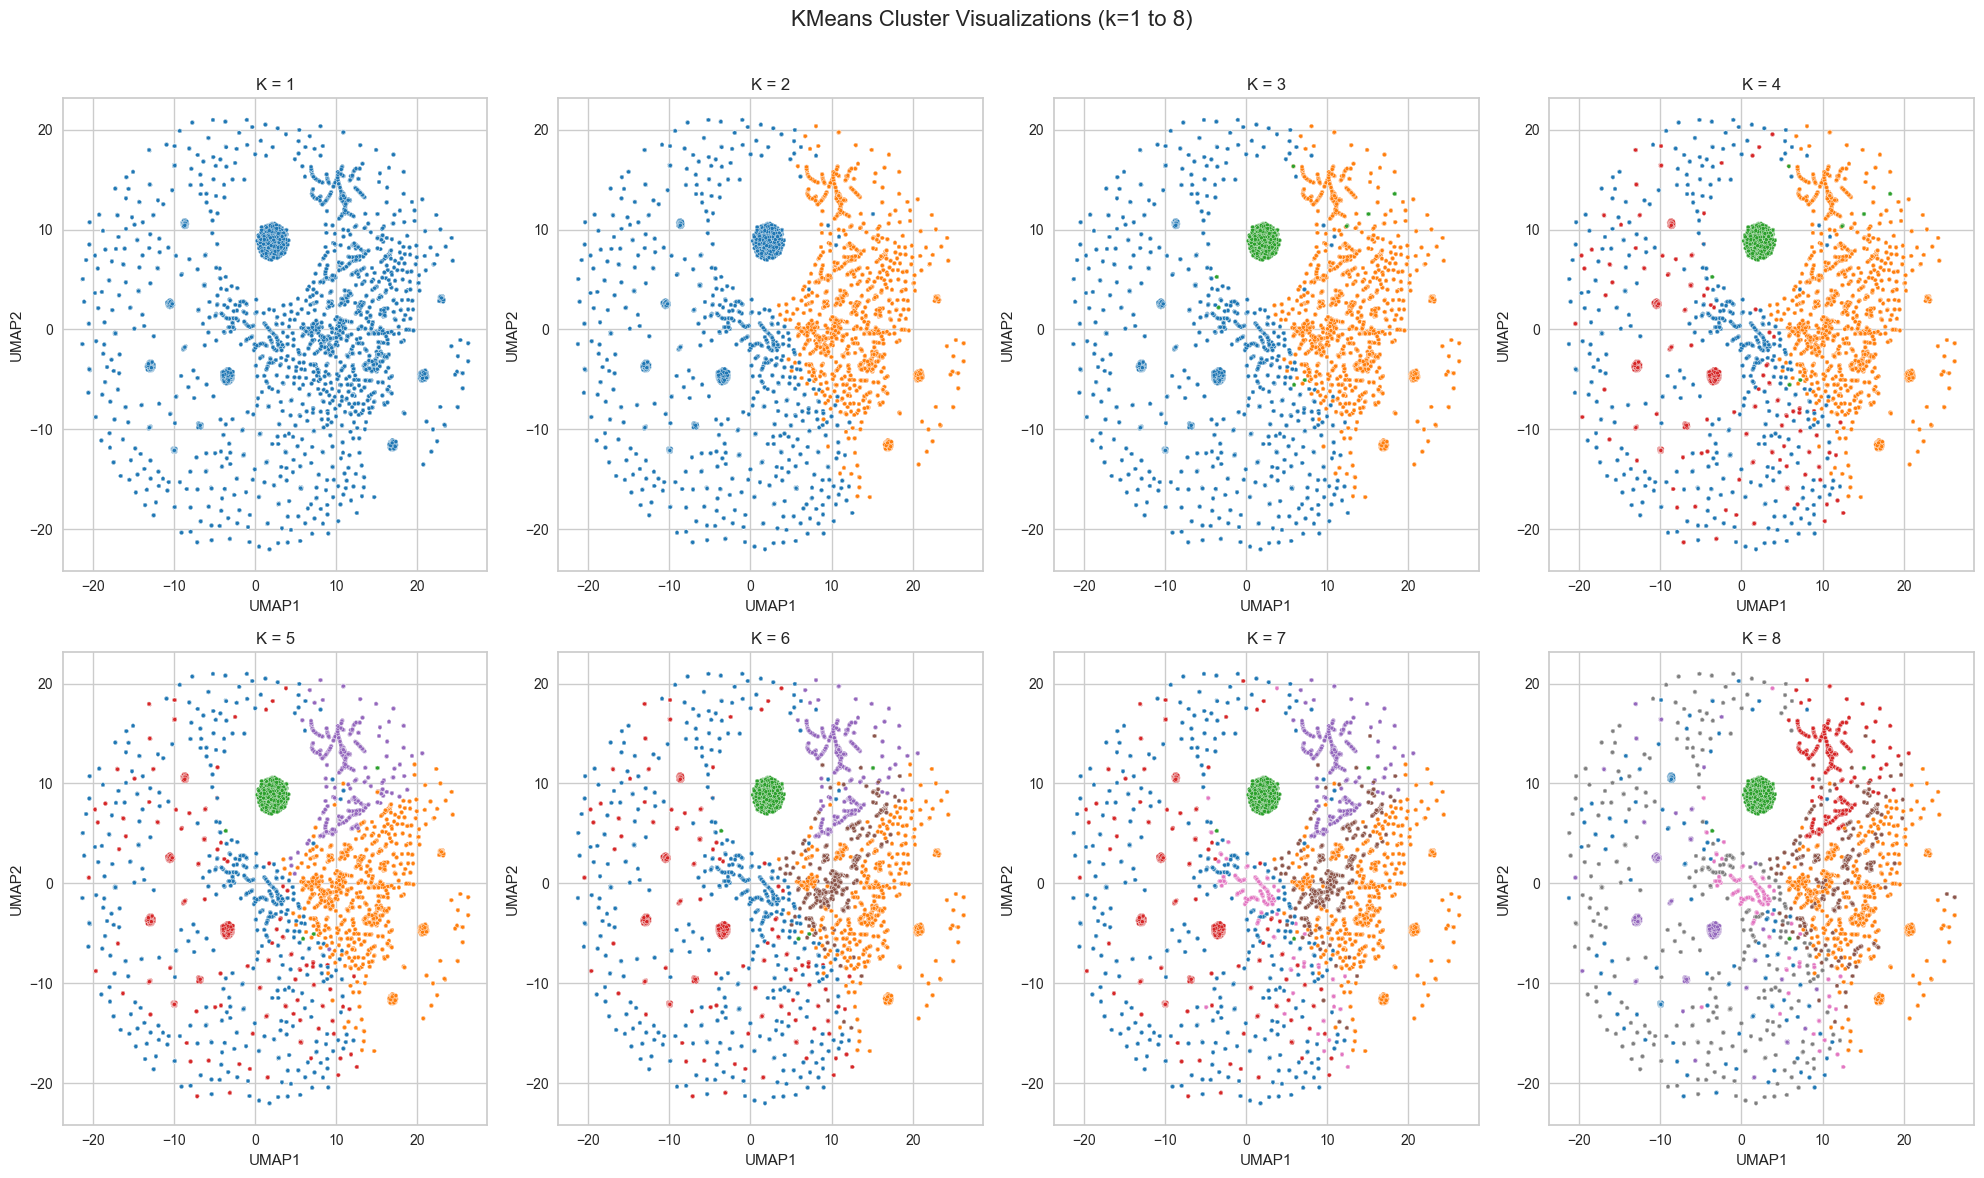

In [ ]:
pca = umap.UMAP()

X_pca = pca.fit_transform(X_scaled)

# Set up plotting space
fig, axes = plt.subplots(2, 4, figsize=(20, 12))
axes = axes.flatten()

# Run KMeans for k=1 to 14 and plot 3d results
for i, k in enumerate(range(1, 9)):
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(X_scaled)

    sns.scatterplot(
        x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, 
        palette='tab10', ax=axes[i], legend=False, s=8
    )
    axes[i].set_title(f'K = {k}')
    axes[i].set_xlabel('UMAP1')
    axes[i].set_ylabel('UMAP2')


plt.suptitle('KMeans Cluster Visualizations (k=1 to 8)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [ ]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=100,
    cluster_selection_epsilon=0.15,
    approx_min_span_tree=False
)

cluster_labels = clusterer.fit_predict(X_scaled)

C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\luca.lucchina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
grouped_df['attack_cluster'] = cluster_labels
X_scaled['attack_cluster'] = cluster_labels
print("Cluster sizes:")
pd.Series(cluster_labels).value_counts().sort_index()

Cluster sizes:


-1    304431
 0      6667
 1      2380
 2      3306
 3      1475
 4      1392
 5     11014
 6      5963
 7      3084
Name: count, dtype: int64

## Clustering Analysis

Apply clustering algorithms and analyze results:
- Cluster visualization
- silhouette score
- Pattern analysis by cluster of the features 

### PCA vis of clusters

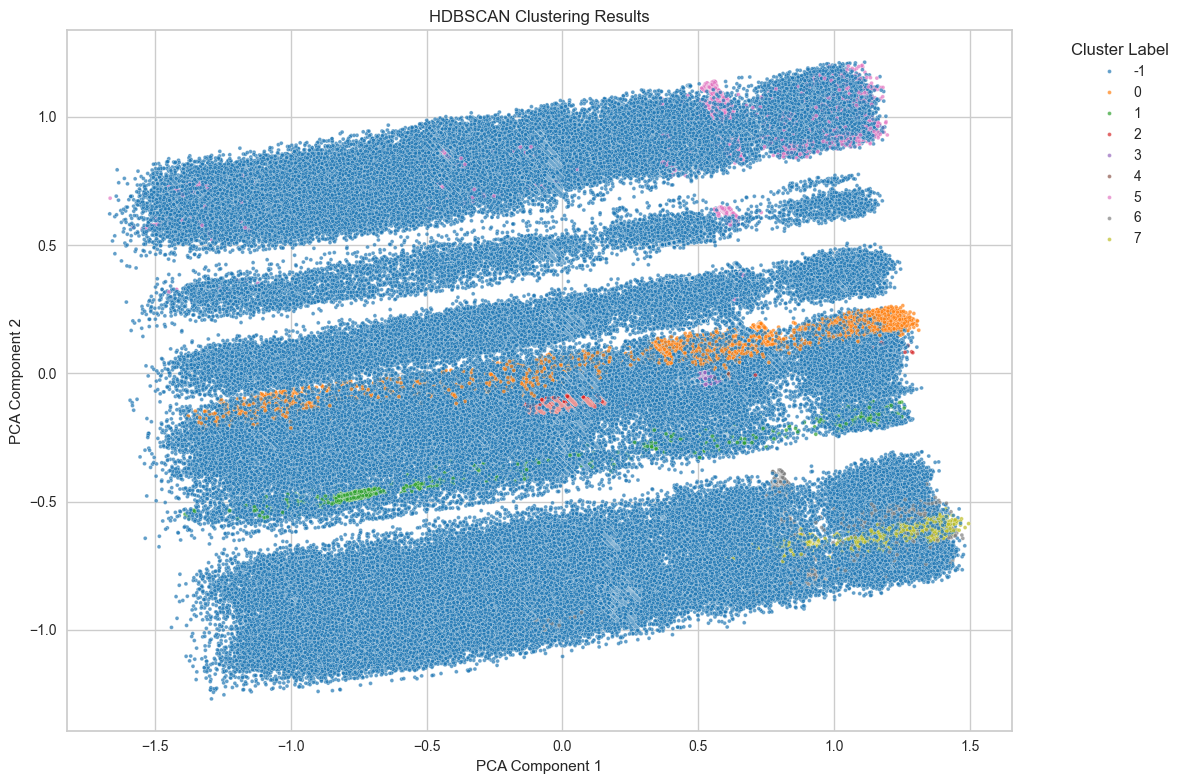

In [ ]:
pca_vis = PCA(n_components=2)
X_vis = pca_vis.fit_transform(X_scaled.drop(columns=['attack_cluster']))
# Plot with noise
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=X_vis[:, 0], y=X_vis[:, 1], hue=cluster_labels, 
    palette='tab10', s=8, legend='full', alpha=0.7
)
plt.title('HDBSCAN Clustering Results')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

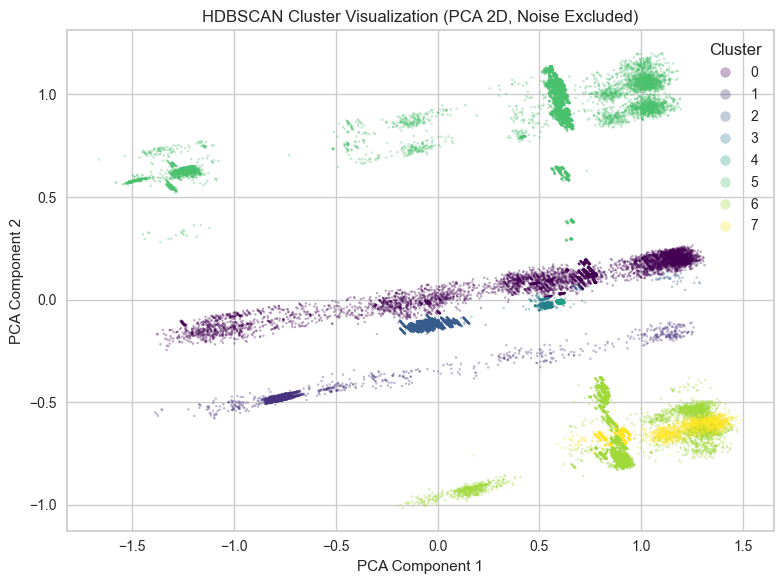

In [ ]:
mask = cluster_labels != -1
X_vis_filtered = X_vis[mask]
cluster_labels_filtered = cluster_labels[mask]

# Plot without noise
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_vis_filtered[:, 0], X_vis_filtered[:, 1],
    c=cluster_labels_filtered, cmap='viridis', alpha=0.3, s=2
)
plt.title("HDBSCAN Cluster Visualization (PCA 2D, Noise Excluded)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.tight_layout()
plt.show()

In [ ]:
if hasattr(X_scaled, 'columns'):
    feature_names = grouped_df.columns
else:
    feature_names = [f'feature_{i}' for i in range(X_scaled.shape[1])]

# Create a DataFrame for PCA loadings
loadings = pd.DataFrame(
    pca_vis.components_.T,
    columns=['PC1', 'PC2'],
    index=feature_names
)
print("PCA Loadings:")
loadings = loadings.reindex(loadings.abs().sum(axis=1).sort_values(ascending=False).index)
loadings

In [ ]:
cluster_means = grouped_df[grouped_df['attack_cluster'] != -1].groupby('attack_cluster').mean(numeric_only=True)

cluster_means_T = cluster_means.T
feature_spread = cluster_means_T.std(axis=1).sort_values(ascending=False)

top_n = 30
top_features = feature_spread.head(top_n)

top_features 


time_seconds_min        16679.958510
time_seconds_max        16473.303520
src_as_encoded_first    14571.157248
pl_length_sum            1513.434453
burst_duration            258.285427
pl_length_mean            230.840908
dst_oct3_first             77.643933
dst_oct2_first             60.057114
dst_lon_first              59.784592
dst_oct1_first             52.935202
src_oct1_first             46.440443
src_lon_first              44.530146
dst_oct4_first             41.961897
src_oct2_first             41.164801
src_oct3_first             35.844003
dst_lat_first              33.474205
src_oct4_first             27.321893
src_lat_first               8.529203
hour_first                  4.605655
minute_first                2.385180
pl_entropy_max              1.606258
pl_entropy_mean             1.568124
pl_entropy_min              1.519018
attacks_in_burst            1.475750
dst_lon_sin_first           0.653105
src_lon_cos_first           0.636829
dst_lat_sin_first           0.540670
d

## Silhouette score

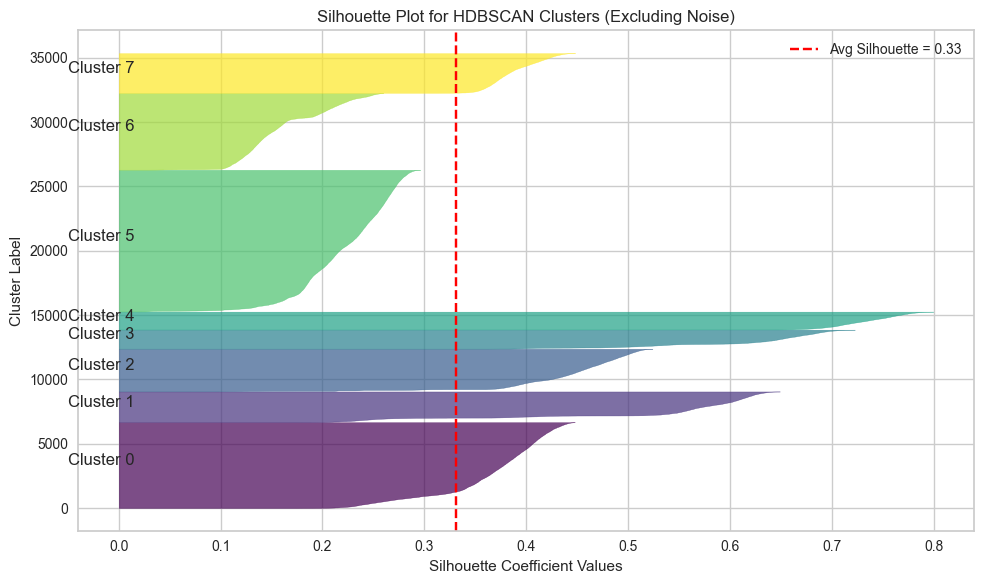

In [ ]:
mask = cluster_labels != -1
X_filtered = X_scaled[mask]
labels_filtered = cluster_labels[mask]

# Compute silhouette scores
silhouette_vals = silhouette_samples(X_filtered, labels_filtered)
avg_silhouette = sil_(X_filtered, labels_filtered)

# Sort for better visualization
sorted_idx = np.argsort(labels_filtered)
sorted_silhouette_vals = silhouette_vals[sorted_idx]
sorted_cluster_labels = labels_filtered[sorted_idx]

# Create silhouette plot
fig, ax = plt.subplots(figsize=(10, 6))
y_lower = 10
unique_labels = np.unique(labels_filtered)

for label in unique_labels:
    label_sil_vals = sorted_silhouette_vals[sorted_cluster_labels == label]
    label_sil_vals.sort()
    y_upper = y_lower + len(label_sil_vals)

    color = plt.cm.viridis(float(label) / (len(unique_labels) - 1))
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, label_sil_vals, facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * len(label_sil_vals), f'Cluster {label}')
    y_lower = y_upper + 10

# Draw average silhouette score line
ax.axvline(avg_silhouette, color="red", linestyle="--", label=f"Avg Silhouette = {avg_silhouette:.2f}")
ax.set_title("Silhouette Plot for HDBSCAN Clusters (Excluding Noise)")
ax.set_xlabel("Silhouette Coefficient Values")
ax.set_ylabel("Cluster Label")
ax.legend()
plt.tight_layout()
plt.show()


# Payload Exploration

This section handles the initial exploration of payload data in hex format:
- Basic payload structure analysis
- Hex data patterns
- Initial feature extraction from hex data

Note: The payloads are currently in 4KB hex format and will be processed without decoding.

# payload analysis TODO later

In [ ]:
import binascii
from collections import Counter

# Function to analyze hex payload without decoding
def analyze_payload(hex_data):
    if pd.isnull(hex_data):
        return {
            'byte_entropy': 0,
            'unique_bytes': 0,
            'max_byte_freq': 0,
            'ascii_ratio': 0,
            'null_ratio': 0,
            'payload_length': 0
        }
    
    try:
        # Work directly with hex string pairs
        # Each byte is represented by 2 hex characters
        hex_pairs = [hex_data[i:i+2] for i in range(0, len(hex_data), 2)]
        total_bytes = len(hex_pairs)
        
        if total_bytes == 0:
            return {
                'byte_entropy': 0,
                'unique_bytes': 0,
                'max_byte_freq': 0,
                'ascii_ratio': 0,
                'null_ratio': 0,
                'payload_length': 0
            }
        
        # Count byte frequencies using hex pairs
        byte_counts = Counter(hex_pairs)
        
        # Calculate byte entropy
        byte_probs = [count/total_bytes for count in byte_counts.values()]
        byte_entropy = -sum(p * np.log2(p) for p in byte_probs)
        
        # Count ASCII and null bytes by looking at hex values
        ascii_bytes = sum(1 for pair in hex_pairs 
                         if 20 <= int(pair, 16) <= 7E)  # 20-7E is printable ASCII
        null_bytes = byte_counts.get('00', 0)
        
        return {
            'byte_entropy': byte_entropy,
            'unique_bytes': len(byte_counts),
            'max_byte_freq': max(byte_counts.values()) / total_bytes,
            'ascii_ratio': ascii_bytes / total_bytes,
            'null_ratio': null_bytes / total_bytes,
            'payload_length': total_bytes
        }
    
    except (ValueError, Exception) as e:
        # Handle invalid hex strings or other errors
        return {
            'byte_entropy': 0,
            'unique_bytes': 0,
            'max_byte_freq': 0,
            'ascii_ratio': 0,
            'null_ratio': 0,
            'payload_length': 0
        }

# Extract payload features
payload_features = pd.DataFrame(df['payload_4kb_hex'].apply(analyze_payload).tolist())

# Add features to main dataframe
for col in payload_features.columns:
    df[f'payload_{col}'] = payload_features[col]

# Print payload feature statistics
print("\nPayload Feature Statistics:")
print(payload_features.describe())

# Visualize payload features
plt.figure(figsize=(15, 5))

# Byte entropy distribution
plt.subplot(131)
plt.hist(df['payload_byte_entropy'].dropna(), bins=50)
plt.title('Payload Byte Entropy Distribution')
plt.xlabel('Byte Entropy')

# ASCII ratio distribution
plt.subplot(132)
plt.hist(df['payload_ascii_ratio'].dropna(), bins=50)
plt.title('ASCII Content Ratio Distribution')
plt.xlabel('ASCII Ratio')

# Payload length distribution
plt.subplot(133)
plt.hist(df['payload_length'].dropna(), bins=50)
plt.title('Payload Length Distribution')
plt.xlabel('Length (bytes)')

plt.tight_layout()
plt.show()

Row 0:
b'\x00\x00\x00\xef\xbf\xbd\xef\xbf\xbdSMBr\x00\x00\x00\x00\x18S\xef\xbf\xbd\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xef\xbf\xbd\xef\xbf\xbd\x00\x00@\x00\x00b\x00\x02PC NETWORK PROGRAM 1.0\x00\x02LANMAN1.0\x00\x02Windows for Workgroups 3.1a\x00\x02LM1.2X002\x00\x02LANMAN2.1\x00\x02NT LM 0.12\x00'

Row 1:
No hex data in the first row.

Row 2:
b'GET / HTTP/1.1\r\nHost: 216.238.89.44:22\r\nUser-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/101.0.4951.41 Safari/537.36\r\nAccept: */*\r\nAccept-Encoding: gzip\r\n\r\n'

Row 3:
b'\x00\x00\x00T\xef\xbf\xbdSMBr\x00\x00\x00\x00\x18\x01(\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00/K\x00\x00\xef\xbf\xbd^\x001\x00\x02LANMAN1.0\x00\x02LM1.2X002\x00\x02NT LANMAN 1.0\x00\x02NT LM 0.12\x00'

Row 4:
No hex data in the first row.

Row 5:
b'GET / HTTP/1.1\r\nHost: 104.238.179.29:22\r\nUser-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) 

In [ ]:

# Visualize payload feature distributions
plt.figure(figsize=(15, 5))

# Entropy vs Payload Length
plt.subplot(131)
plt.scatter(df['payload_byte_entropy'], df['payload_length'], alpha=0.5)
plt.xlabel('Byte Entropy')
plt.ylabel('Payload Length')
plt.title('Entropy vs Length')

# ASCII Ratio Distribution
plt.subplot(132)
plt.hist(df['payload_ascii_ratio'], bins=50)
plt.xlabel('ASCII Ratio')
plt.ylabel('Count')
plt.title('ASCII Content Distribution')

# Unique Bytes vs Length
plt.subplot(133)
plt.scatter(df['payload_unique_bytes'], df['payload_length'], alpha=0.5)
plt.xlabel('Unique Bytes')
plt.ylabel('Payload Length')
plt.title('Byte Diversity vs Length')

plt.tight_layout()

# Payload Analysis

Analyze the 4KB hex payloads to extract useful features:
- Byte frequency distributions
- Common patterns and signatures
- Payload structure analysis
- Protocol-specific patterns

In [ ]:
import codecs
import pandas as pd
import binascii

# Initialize decoder
hex_decoder = codecs.getdecoder("hex_codec")

# Store decoded payloads
decoded_payloads = []

# Loop through your DataFrame rows
for index, row in df.head(13).iterrows():
    hex_data = row.get("payload_4kb_hex")
    
    if pd.notnull(hex_data):
        try:
            # First decode hex to bytes
            decoded_bytes = hex_decoder(hex_data)[0]
            
            # Try UTF-8 first
            try:
                decoded_text = decoded_bytes.decode("utf-8")
            except UnicodeDecodeError:
                # Fall back to Latin-1
                decoded_text = decoded_bytes.decode("latin1")
            
            # Print and store decoded result
            print(f"Row {index}:\n{decoded_text}\n")
            decoded_payloads.append(decoded_text)

        except (UnicodeDecodeError, binascii.Error) as e:
            print(f"Row {index}: Binary or malformed hex - {e}\n")
            decoded_payloads.append("[BINARY DATA]")
        except Exception as e:
            print(f"Row {index}: Unexpected error - {e}\n")
            decoded_payloads.append("[DECODING ERROR]")
    
    else:
        print(f"Row {index}: No hex data.\n")
        decoded_payloads.append("[EMPTY]")


Row 0:
   ��SMBr    S�              ��  @  b PC NETWORK PROGRAM 1.0 LANMAN1.0 Windows for Workgroups 3.1a LM1.2X002 LANMAN2.1 NT LM 0.12 

Row 1: No hex data.

Row 2:
GET / HTTP/1.1
Host: 216.238.89.44:22
User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/101.0.4951.41 Safari/537.36
Accept: */*
Accept-Encoding: gzip



Row 3:
   T�SMBr    (              /K  �^ 1 LANMAN1.0 LM1.2X002 NT LANMAN 1.0 NT LM 0.12 

Row 4: No hex data.

Row 5:
GET / HTTP/1.1
Host: 104.238.179.29:22
User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36
Accept: */*
Accept-Encoding: gzip



Row 6: No hex data.

Row 7: No hex data.

Row 8: No hex data.

Row 9:
  �\��
��g������
![-!	��Jm��@{�O �)�|�'L� (�a�
4��.{*4� &�+�/�,�0̨̩�	��
� � � / 5� 
  �      cf.06151953.xyz       
 
  �      +  3 & $   X.;���+-�mR�t�!�J�0�/�2�0̷Q�N


In [ ]:
import codecs
import pandas as pd

hex_decoder = codecs.getdecoder("hex_codec")

decoded_payloads = []  # store results here

for index, row in df.head(13).iterrows():
    hex_data = row["payload_4kb_hex"]
    if pd.notnull(hex_data):
        try:
            decoded_bytes = hex_decoder(hex_data)[0]
            decoded_text = decoded_bytes.decode("utf-8")
            print(f"Row {index}:\n{decoded_text}\n")
            decoded_payloads.append(decoded_text)

        except UnicodeDecodeError:
            print(f"Row {index}: Binary or non-UTF-8 data\n")
            decoded_payloads.append("[BINARY DATA]")
        except Exception as e:
            print(f"Row {index}: Error decoding - {e}\n")
            decoded_payloads.append("[DECODING ERROR]")
    else:
        print(f"Row {index}: No hex data.\n")
        decoded_payloads.append("[EMPTY]")

Row 0:
   ��SMBr    S�              ��  @  b PC NETWORK PROGRAM 1.0 LANMAN1.0 Windows for Workgroups 3.1a LM1.2X002 LANMAN2.1 NT LM 0.12 

Row 1: No hex data.

Row 2:
GET / HTTP/1.1
Host: 216.238.89.44:22
User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/101.0.4951.41 Safari/537.36
Accept: */*
Accept-Encoding: gzip



Row 3:
   T�SMBr    (              /K  �^ 1 LANMAN1.0 LM1.2X002 NT LANMAN 1.0 NT LM 0.12 

Row 4: No hex data.

Row 5:
GET / HTTP/1.1
Host: 104.238.179.29:22
User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36
Accept: */*
Accept-Encoding: gzip



Row 6: No hex data.

Row 7: No hex data.

Row 8: No hex data.

Row 9:
  �\��
��g������
![-!	��Jm��@{�O �)�|�'L� (�a�
4��.{*4� &�+�/�,�0̨̩�	��
� � � / 5� 
  �      cf.06151953.xyz       
 
  �      +  3 & $   X.;���+-�mR�t�!�J�0�/�2�0̷Q�N
